## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled dataset of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 50 training runs in total** (where one training run consists of fitting a DL model, with as many epochs as you think are needed, and with fixed model specifications and fixed hyperparameter settings - that is, not including hyper-parameter optimisation). In addition, because it is intended to be for a lightweight app, your manager wants to to **limit the number of total parameters in each network to a maximum of 500,000.** Also, the data has already been double-checked for problems by an in-house data wrangling team and all erroneous data has already been identified and then fixed by the client, so you **do not need to check for erroneous data** in this case.

In addition, you are told to **create a fixed validation set and any necessary test sets using _only_ the supplied _testing_ dataset.** It is unusual to do this, but here the training set contains a lot of non-independent, augmented images and it is important that the validation images must be totally independent of the training data and not made from augmented instances of training images.

The clients have asked to be informed about the following:
 - **unbiased median accuracy** estimate of the letter predictions from a deep learning model
 - the letter with the highest individual accuracy
 - the letter with the lowest individual accuracy
 - the three most common single types of error (i.e. where one letter is being incorrectly labelled as another)
 
Your manager has asked you to create a jupyter notebook that shows the following:
 - loading the data and displaying a sample of each letter
 - training and optimising both **densely connected** *and* **CNN** style models
 - finding the best single model, subject to a rapid turn-around and corresponding limit of 50 training runs in total
 - reporting clearly and concisely what networks you have tried, the method you used to optimise them, the associated learning curves, the number of total parameters in each, their summary performance and the selection process used to pick the best model
     - this should be clear enough that another employee, with your skillset, should be able to take over from you and understand your code and your methods
 - results from the model that is selected as the best, showing the information that the clients have requested
 - it is hoped that the median accuracy will exceed 94% overall and better than 85% for every individual letter, and you are asked to report (in addition to the client's requests):
     - the overall mean accuracy
     - the accuracy for each individual letter
     - a short written recommendation (100 words maximum) regarding how likely you think it is to achieve these goals either with the current model or by continuing to do a small amount of model development/optimisation


In [77]:
# Set the seed for reproducibility
import numpy as np
import random
import tensorflow as tf
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

## **SECTION 1: Load the data, display sample image and inititate baseline model**

### **Load data, display images**

In [78]:
import pandas as pd
# Load the dataset
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

Now, we try to see the information of the dataset and also get an overvir=ew on the dataset given

In [79]:
info_train_data = train_data.info()
print(info_train_data)
train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 1025 entries, label to pixel1024
dtypes: int64(1025)
memory usage: 214.7 MB
None


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel985,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,165,166,168,170,170,171,171,171,172,172,172,172,172,171,171,170,170,169,111,118,127,134,139,143,146,...,207,207,206,206,206,204,203,202,142,151,160,172,196,196,196,196,196,190,190,190,135,96,176,205,207,207,207,207,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,157,157,157,157,157,158,158,158,158,158,158,158,158,156,154,154,153,152,151,149,149,148,147,146,144,143,143,138,108,108,158,158,158,157,157,157,157,...,175,175,175,175,175,149,149,149,135,135,135,135,135,116,139,173,200,200,200,200,200,198,198,198,140,140,140,149,149,149,149,163,175,175,175,175,175,149,149,149
2,2,187,188,188,188,188,188,188,188,188,188,188,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,83,83,83,83,188,188,188,188,188,188,188,...,200,199,199,199,198,195,195,195,198,198,198,198,198,166,132,114,89,79,132,188,210,210,210,210,210,209,206,205,204,203,202,201,200,199,199,199,198,195,195,195
3,2,211,211,212,212,212,212,212,212,211,211,211,211,211,211,209,208,208,207,206,203,202,201,200,198,197,197,197,197,171,54,54,54,212,212,212,212,212,212,212,...,233,231,230,229,229,229,229,216,58,58,58,58,58,60,60,60,60,60,19,19,159,255,255,255,255,255,239,239,237,236,235,234,233,231,230,229,229,229,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,191,191,191,191,190,192,193,193,193,193,193,194,194,194,194,194,194,166,167,170,172,176,179,180,...,163,163,164,179,179,179,179,179,105,106,106,106,106,106,175,199,199,199,199,199,178,152,150,150,150,150,118,105,105,108,133,163,163,163,164,179,179,179,179,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,194,194,194,194,194,195,195,196,196,196,196,196,197,197,197,197,197,197,197,197,196,195,195,189,189,190,190,192,193,193,...,234,234,234,234,234,225,225,225,82,82,84,85,85,87,87,87,87,113,216,216,216,216,216,189,175,175,155,165,165,165,165,200,234,234,234,234,234,225,225,225
27451,23,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,154,157,158,160,161,163,...,198,198,198,196,195,195,195,194,66,67,67,67,67,67,65,62,61,41,37,38,187,202,202,202,202,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,175,175,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,178,174,174,175,175,...,209,208,206,204,203,202,200,200,217,217,217,218,218,218,218,218,218,211,203,200,189,171,157,145,136,129,128,196,209,209,209,209,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,191,191,193,193,193,193,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,181,184,185,187,189,190,...,102,102,102,93,93,93,93,93,136,136,136,136,136,135,136,136,137,144,144,144,197,200,200,200,200,200,196,196,170,149,119,102,102,102,102,93,93,93,93,93


Before getting to visualize the dataset, we need to see the labels given in tha dataset(unique labels) (Since we dont have J and Z, it should be 26 - 2 = 24 classes)

In [80]:
# Represent the unique labels in train data
unique_label = train_data['label'].unique()
unique_label

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14], dtype=int64)

In [81]:
# Sorting for a better view
unique_label.sort()
unique_label

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Now, we can confirm we have 24 classes

In [82]:
info_test_data = test_data.info()
print(info_test_data)
test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 1025 entries, label to pixel1024
dtypes: int64(1025)
memory usage: 56.1 MB
None


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel985,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
0,6,149,149,150,150,150,151,151,151,151,152,152,152,152,152,153,153,153,153,153,153,153,153,153,153,152,152,151,151,150,150,150,149,150,150,150,150,150,151,151,...,127,112,120,120,120,120,120,113,75,75,75,75,76,76,82,134,168,168,168,168,168,155,149,149,149,149,149,148,148,148,148,148,127,112,120,120,120,120,120,107
1,5,126,128,131,132,133,134,135,135,136,138,138,138,138,138,139,139,142,142,142,142,142,140,139,139,137,137,136,135,134,134,134,132,129,129,131,132,133,134,135,...,194,186,186,184,184,184,182,181,172,174,177,178,178,179,181,183,187,187,187,187,187,175,165,154,118,107,100,104,194,194,194,194,194,186,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,182,182,185,185,185,185,185,185,185,185,185,185,183,183,182,181,178,86,88,92,96,105,123,135,...,242,230,230,227,226,225,224,222,89,91,94,111,136,154,167,184,184,184,184,225,225,225,225,225,195,188,185,185,242,242,242,242,242,230,230,227,226,225,224,222
3,0,203,205,207,207,207,209,210,210,210,210,210,210,210,209,209,210,210,210,210,210,210,209,210,210,210,210,210,209,209,209,209,207,206,206,207,207,207,209,210,...,253,253,253,255,255,255,255,255,103,103,103,103,103,208,231,231,231,231,231,227,209,190,182,182,159,159,159,248,248,248,253,253,253,253,253,255,255,255,255,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,204,204,204,216,217,217,217,217,217,200,200,200,195,194,193,190,189,187,185,190,191,193,195,199,201,202,...,64,49,49,53,53,55,55,55,149,150,150,150,150,151,151,151,151,151,124,84,111,111,111,111,111,103,84,75,64,64,64,64,64,49,49,53,53,53,53,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,135,135,135,135,119,108,105,121,133,143,148,156,160,162,164,168,171,173,175,178,179,181,182,184,185,185,186,186,186,186,186,137,137,137,135,135,119,108,...,184,184,184,184,184,176,167,166,140,140,157,157,157,157,157,125,104,104,118,167,167,167,167,167,154,141,139,139,135,125,118,180,184,184,184,184,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,176,176,176,178,178,178,178,178,178,178,178,178,178,178,178,177,176,176,176,174,174,173,173,159,159,161,164,166,166,171,...,214,214,213,211,210,210,209,208,189,192,196,199,199,208,230,230,230,230,230,201,197,187,187,187,169,136,213,213,213,214,214,214,214,214,213,211,210,210,209,208
7169,2,190,191,191,191,191,191,192,192,192,192,193,193,193,193,193,192,192,192,192,192,192,189,189,189,188,188,188,187,186,185,184,183,193,193,193,191,191,191,192,...,214,214,214,213,211,211,209,208,215,215,215,215,215,215,208,208,208,207,203,196,170,155,213,216,216,216,216,216,216,216,216,215,214,214,214,213,211,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,229,234,234,234,237,237,237,240,241,241,241,241,242,243,243,243,243,243,241,239,239,239,239,206,206,208,209,214,216,218,...,255,255,237,113,91,77,77,77,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,249,231,188,176,255,255,255,255,255,255,237,113,91,70,70,63


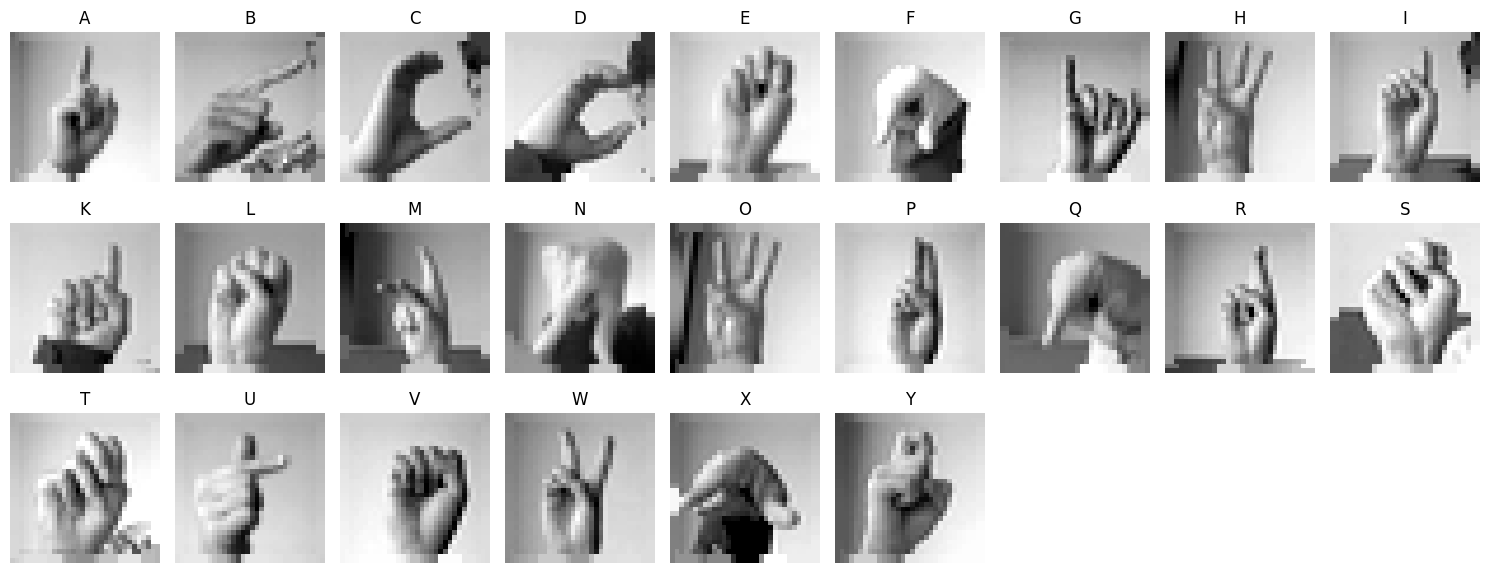

In [83]:
import matplotlib.pyplot as plt 
# Get unique labels
letters_train = np.unique(train_data['label'])
images_train = train_data.drop(columns=['label']).values

# Reshape the image pixels to 32*32
images_train = images_train.reshape(-1, 32, 32)

# Define grid size
n_rows = 3
n_cols = 9  # Adjust these based on the number of unique classes in dataset

# Plot images
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))
axes = axes.flatten()

# Loop through the unique labels and plot one example of each
for i, letter in enumerate(letters):
    ax = axes[i]
    idx = np.where(letters_train == letter)[0][0]
    ax.imshow(images_train[idx], cmap='gray')
    ax.set_title(chr(letter + 65))  # Convert number to alphabet according to ASCII 
    ax.axis('off')

# Hide any unused subplots
for ax in axes[len(letters_train):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Since there are some of the dataset need downsampling/ upsampling since the imbalance between counts in each class, we can check on this issues by plotting the distributions of the training dataset classes

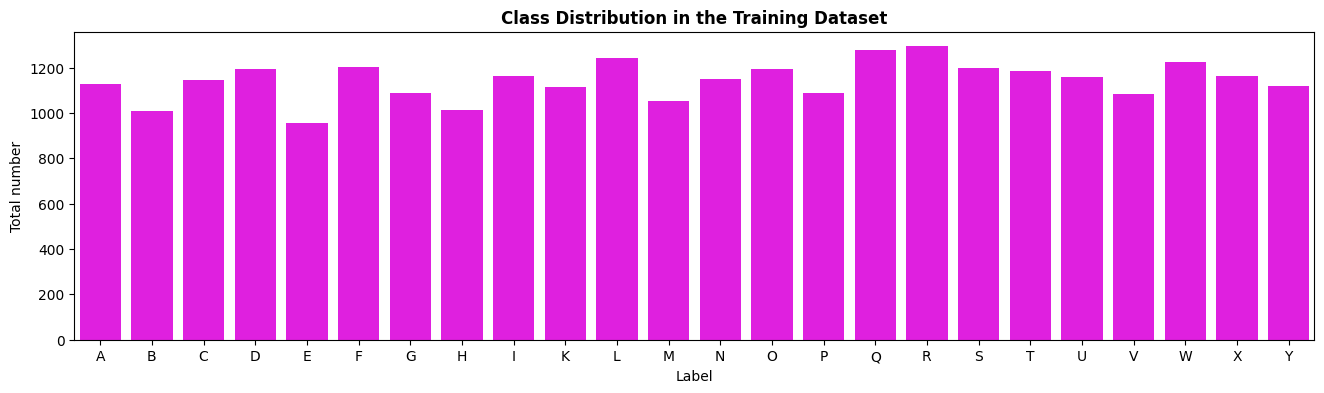

In [85]:
import seaborn as sns
plt.figure(figsize = (16,4))
sns.countplot(x = train_data['label'], color='magenta')
plt.title("Class Distribution in the Training Dataset", fontweight = 'bold')
plt.xlabel('Label')
plt.ylabel('Total number')
plt.xticks(ticks = np.arange(0,24), labels=[chr(i+65) for i in letters_train])
plt.show()

As we can see, the distribution is quite balanced, we do not need to handle the dataset anymore. However, as mentioned before, we do not have J and Z. The tricky part is J is in the middle of dataset, so it is better that we should adjust the labels for each class to make sure no J and Z are included.

Before that, we need a better name for the features and labels

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Extract labels and images
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values


In [87]:
# Adjust labels to be in range 0-23 instead of 0-24
y_train = [i if i < 9 else i - 1 for i in y_train]
y_test = [i if i < 9 else i - 1 for i in y_test]

# Reshape the image to 30*30
X_train = X_train.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Create a fixed validation set and a test set from the testing data
X_val, X_final_test, y_val, y_final_test = train_test_split(X_test, y_test, stratify= y_test, test_size=0.5, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=24)
y_val = to_categorical(y_val, num_classes=24)
y_final_test = to_categorical(y_final_test, num_classes=24)

**Note**: 

After we adjust the labels, we need to `reshape` 1024 pixels back to 32*32 matrix, it is better to treat the images as 2D version than 1D. And we didvided the pixel values by 225 to `normalise` the amount. The point to perform this is the complex models (deep learning models) prefer working with smnall number( centering at 0) for better compuatation ability as well as mitigating the problems related to gradients (exploding/ vanishing if the number is too large/small)

Besides, we use `onehot encoded` label to utilize the `categorical entropy` since:

- Flexibility: Works well with complex architectures and operations that require explicit class representations.
 
- Interpretability: Easier to understand and debug, as each label is a vector with a clear class assignment.

- Consistency: Aligns naturally with softmax outputs, making comparisons straightforward.

Since the request of the task is to utilise the test data to form the validatyion data and test data, we can `split` the test dataset by half and use `stratify` while splitting since stratification ensures each class is proportionally represented in training and test/validation splits, preserving class distribution. This leads to balanced learning, accurate model evaluation, and reduced bias, especially in datasets with class imbalances.

### **BaseLine Model Forming**

The task includes creating 2 base models (Densely Connected - Convolutional Neural Network), we can perform the creation. However, we need to evaluate and assess the efficiency of models for later optimzation, thus, the code blocks below helps visualizing the model performance better

In [88]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    # Set up the figure size and layout
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


#### **DNN**

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten



# Define the densely connected model
dense_model_base = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(256, activation='relu'),
    Dense(24, activation='softmax')
])

# Compile the model
dense_model_base.summary()


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,568 (1.02 MB)

 Trainable params: 268,568 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

The DNN, we have total params: 268,568 and we have three layers (Flatten, Dense6, Dense7). Here we use the epoch of 20 for better running and also appropraitely perform the learning process of model, we compile the optimiser (Adam)

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2717 - loss: 2.5200 - val_accuracy: 0.5198 - val_loss: 1.5628
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6409 - loss: 1.1913 - val_accuracy: 0.6163 - val_loss: 1.2386
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7487 - loss: 0.8328 - val_accuracy: 0.6528 - val_loss: 1.1195
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.6362 - val_accuracy: 0.6746 - val_loss: 1.0433
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8525 - loss: 0.5020 - val_accuracy: 0.6916 - val_loss: 1.0215
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8840 - loss: 0.3989 - val_accuracy: 0.6955 - val_loss: 1.0335
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 0.3185 - val_accuracy: 0.6949 - val_loss: 1.0487
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9314 - loss: 0.2547 - val_accuracy: 0.

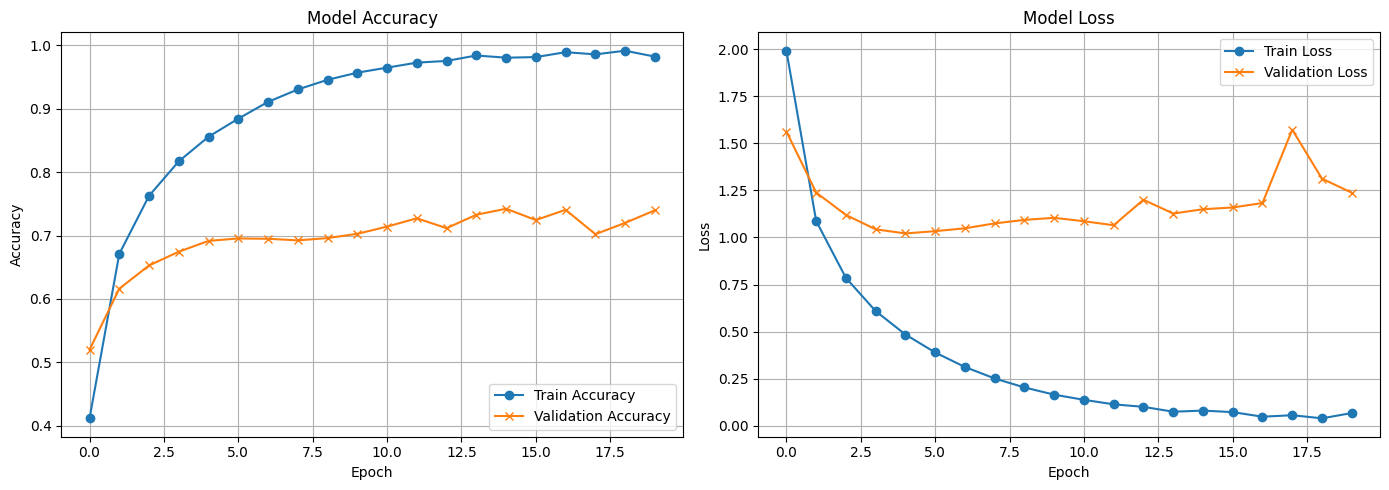

In [90]:
set_seed(42)
dense_model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_dense_base = dense_model_base.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
plot_learning_curve(history_dense_base)

As we can see, DNN has an overfitting problem with the accuracy and loss rate of train data is higher than the validation

#### **CNN**

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# Define the CNN model
cnn_model_base = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(24, activation='softmax')
])
cnn_model_base.summary()


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,968 (160.03 KB)

 Trainable params: 40,968 (160.03 KB)

 Non-trainable params: 0 (0.00 B)

For the CNN model, we have 2 max_pooling, 2 dense layer and 2 convolution with the number of parameters is 40,968

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3729 - loss: 2.1929 - val_accuracy: 0.7529 - val_loss: 0.6950
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9193 - loss: 0.2710 - val_accuracy: 0.8653 - val_loss: 0.4581
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9886 - loss: 0.0467 - val_accuracy: 0.8985 - val_loss: 0.4239
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9977 - loss: 0.0115 - val_accuracy: 0.8996 - val_loss: 0.4749
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 0.9010 - val_loss: 0.4848
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9088 - val_loss: 0.5621
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9046 - val_loss: 0.5537
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.

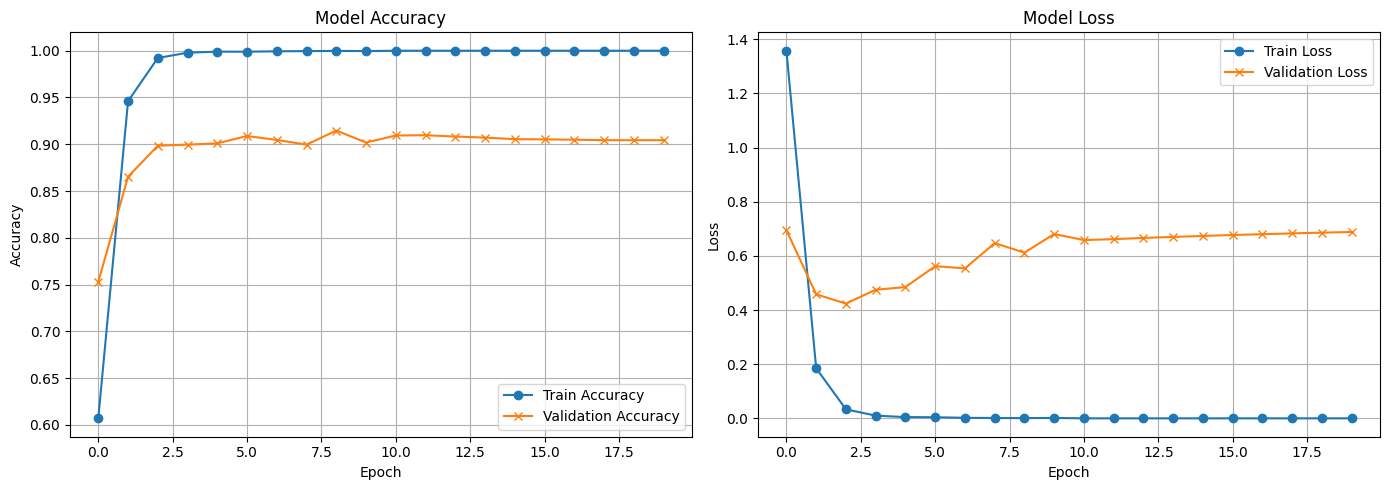

In [92]:
# Compile the model
set_seed(42)
cnn_model_base.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_base = cnn_model_base.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
plot_learning_curve(history_cnn_base)

The CNN model is better, however, the model loss increases and plateaus at 0.7, indicating room for improvement

## **SECTION 2: Model Optimization**

Before we optimse the models, we should devise visualization fucntion to help with assessing and choosing the optimizing path for model

In [94]:
# Function to plot the training and validation metrics for different model architectures
def plot_model_comparison(histories):
    plt.figure(figsize=(14, 10))
    
    # Set custom colors for each architecture
    colors = ['blue', 'green', 'red']
    line_styles = ['-', '--', ':']

    # Plot Training Accuracy
    plt.subplot(2, 2, 1)
    for (key, history), color, line_style in zip(histories.items(), colors, line_styles):
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], label=f'{key}', color=color, linestyle=line_style)
    plt.title('Train Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Validation Accuracy
    plt.subplot(2, 2, 2)
    for (key, history), color, line_style in zip(histories.items(), colors, line_styles):
        epochs = range(1, len(history.history['val_accuracy']) + 1)
        plt.plot(epochs, history.history['val_accuracy'], label=f'{key}', color=color, linestyle=line_style)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Training Loss
    plt.subplot(2, 2, 3)
    for (key, history), color, line_style in zip(histories.items(), colors, line_styles):
        epochs = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs, history.history['loss'], label=f'{key}', color=color, linestyle=line_style)
    plt.title('Train Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot Validation Loss
    plt.subplot(2, 2, 4)
    for (key, history), color, line_style in zip(histories.items(), colors, line_styles):
        epochs = range(1, len(history.history['val_loss']) + 1)
        plt.plot(epochs, history.history['val_loss'], label=f'{key}', color=color, linestyle=line_style)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()


### **DNN Optimzation**

Since each components passes can impact the performance of model, we can implement trials on:

- Architecture
- Activation Function
- Learning Rate
- Optimizer
- Kernel Initializer
- Regularization
- Early Stopping and Learning Rate Reduction Callback

The last 2 ones are not hyperparameter tuning, however since:

- L2 Regularization adds a penalty to the loss function based on the squared magnitude of the model's weights. This helps prevent overfitting by discouraging the model from assigning too much importance to any single feature, promoting simpler models that generalize better to unseen data.

- Early Stopping: Prevents overfitting by halting training when validation performance stops improving.

- Learning Rate Reduction: Helps the model converge by lowering the learning rate when progress slows, allowing finer adjustments in later epochs.

We can give a try on that

We now have the first Dnn model to customize. 

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def build_custom_dnn(neuron_list, activation_type='relu', initializer='glorot_uniform'):
    neural_net = Sequential()
    neural_net.add(Flatten(input_shape=(32, 32, 1), name='input_flatten'))
    
    # Adding each hidden layer dynamically
    for index, units in enumerate(neuron_list):
        neural_net.add(Dense(units, activation=activation_type, kernel_initializer=initializer, name=f'layer_{index+1}'))

    # Final layer
    neural_net.add(Dense(24, activation='softmax', kernel_initializer=initializer, name='output_layer'))
    
    
    return neural_net


Since the requirement is the total of params in each model is less than 500000, so we try with architectures: 
- [256, 128, 64] - 305112 params (3 hidden layers)
- [256, 128] - 298392 params (2 hidden layers)
- [256] - 268568 params (1 hidden layer)

#### **DNN Architecture Optimization**

c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Parameters in model for architecture [256, 128, 64]: 305112
Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1746 - loss: 2.7272 - val_accuracy: 0.4824 - val_loss: 1.6245
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5831 - loss: 1.2493 - val_accuracy: 0.6177 - val_loss: 1.1571
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7459 - loss: 0.7493 - val_accuracy: 0.6651 - val_loss: 1.0431
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8416 - loss: 0.4737 - val_accuracy: 0.6868 - val_loss: 1.0681
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8887 - loss: 0.3358 - val_accuracy: 0.7142 - val_loss: 1.0687
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9336 - loss: 0.2097 - val_accuracy: 0.7390 - val_loss: 1.0462
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 0.1633 - val_accuracy: 0.7432 - val_loss: 1.1450
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2

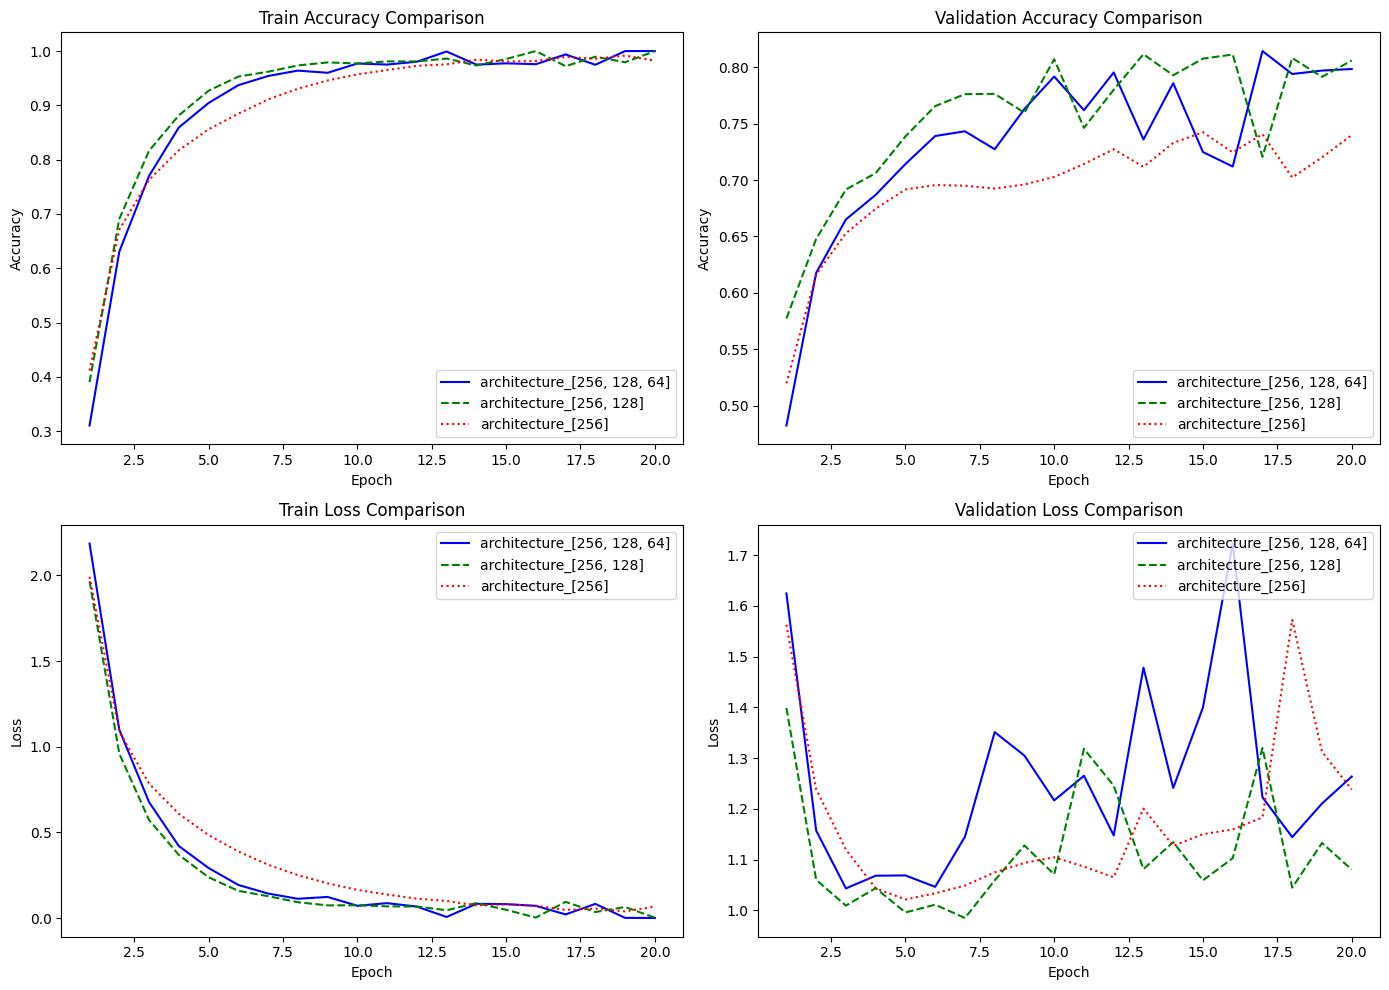

In [137]:
# Dictionary to store training histories
training_histories = {}

# Initialize different network architectures for evaluation
architectures = [[256, 128, 64], [256, 128], [256]]

# Process each architecture
for architecture in architectures:
    set_seed(42)

    # Creating and compiling the model
    model = build_custom_dnn(architecture)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Output the model's parameter count
    print(f"Parameters in model for architecture {architecture}: {model.count_params()}")

    # Training the model
    training_history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val)
    )

    # Saving the history for later comparison
    training_histories[f"architecture_{architecture}"] = training_history

# Plot the performance of different architectures
plot_model_comparison(training_histories)

**Observations:**

***Train Accuracy:***

- All architectures achieved high train accuracy, with all models converging to almost perfect accuracy.

- The model with the architecture [256, 128, 64] and [256, 128] seem to have very similar performance, slightly outperforming [256].

***Validation Accuracy:***

- [256, 128]: This model showed the most consistent and highest validation accuracy, peaking early and maintaining a higher average throughout the epochs.
  
- [256, 128, 64]: This model also performed well but had more fluctuations in validation accuracy. Despite these fluctuations, it still maintained competitive accuracy.
  
- [256]: This model consistently underperformed in validation accuracy compared to the others.
  
***Train Loss:***

All models showed a similar reduction in training loss, reaching very low values. However, the differences in training loss among the models were minimal, suggesting they all learned the training data effectively.

***Validation Loss:***

- [256, 128]: This architecture showed the lowest validation loss overall, indicating it generalizes better to unseen data.
  
- [256, 128, 64]: While this model had competitive validation loss, it exhibited higher fluctuations, suggesting possible overfitting.
  
- [256]: This model had the highest validation loss, indicating less effective generalization.
  
***Conclusion:***

**The architecture [256, 128] appears to be the most optimal choice.** It balances between complexity (with two hidden layers) and performance, achieving the highest validation accuracy and the lowest validation loss with less fluctuation. This suggests that it generalizes better to unseen data compared to the other architectures.

#### **DNN Activation Function Optimization**

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3091 - loss: 2.3266 - val_accuracy: 0.5722 - val_loss: 1.3789
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7247 - loss: 0.8537 - val_accuracy: 0.7474 - val_loss: 0.8495
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8536 - loss: 0.4411 - val_accuracy: 0.7596 - val_loss: 0.8671
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - loss: 0.3044 - val_accuracy: 0.7881 - val_loss: 0.8063
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9418 - loss: 0.1761 - val_accuracy: 0.7819 - val_loss: 0.8945
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9521 - loss: 0.1437 - val_accuracy: 0.8098 - val_loss: 0.8136
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9811 - loss: 0.0681 - val_accuracy: 0.7775 - val_loss: 0.8654
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9882 - loss: 0.0436 - val_accuracy: 0.

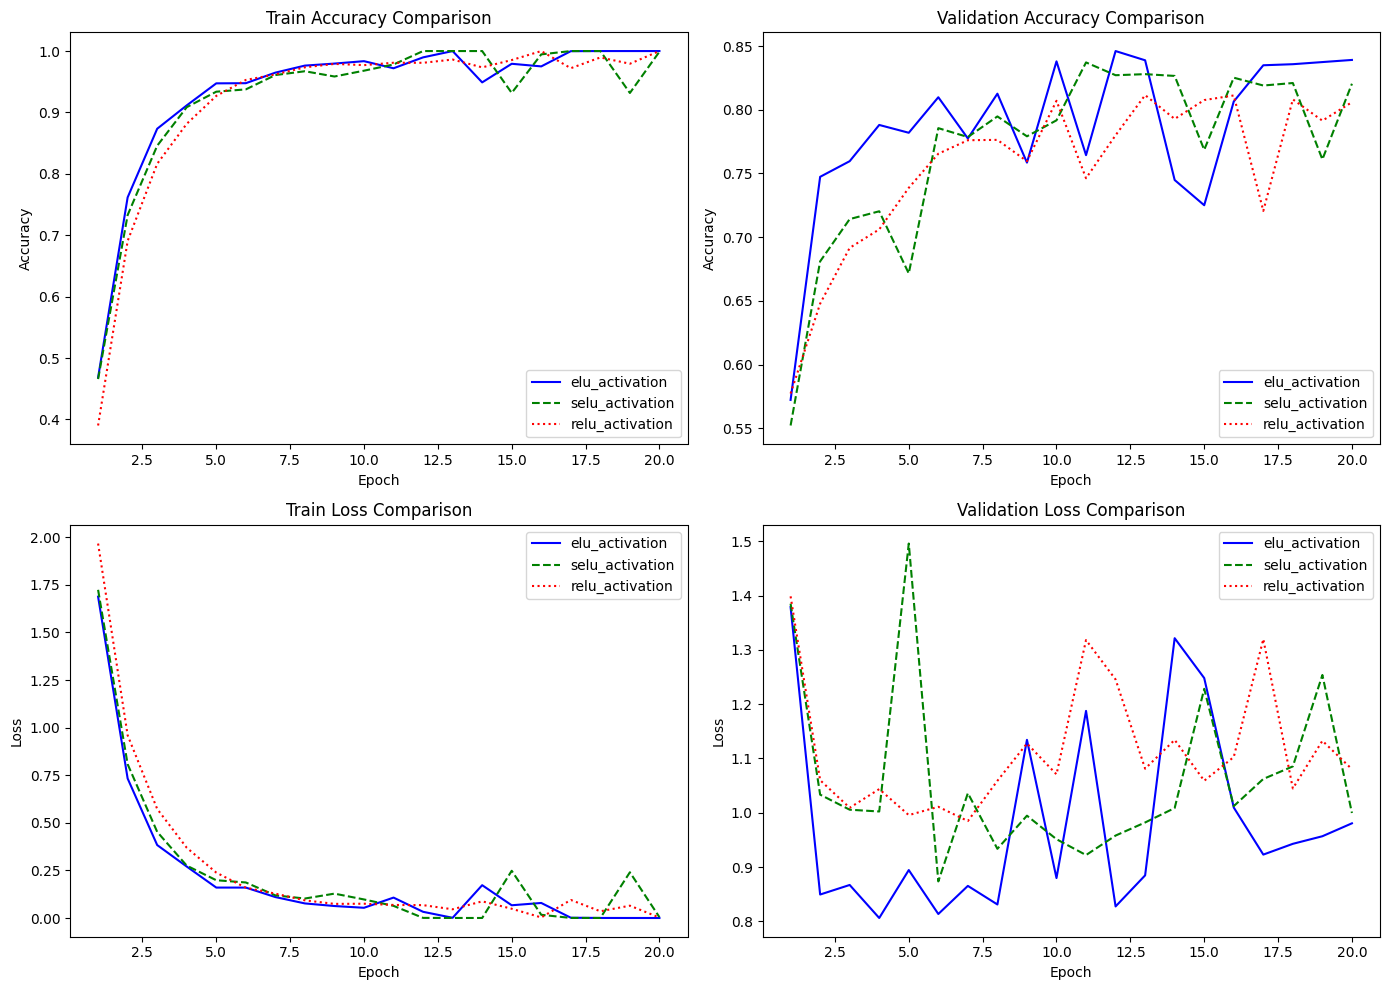

In [97]:
# List of activation functions to evaluate
activation_functions = ['elu', 'selu', 'relu']

# Dictionary to hold training results for different activation functions
results_by_activation = {}

# Iterate over each activation function to compare their performance
for activation in activation_functions:
    set_seed(42)  # Ensuring reproducibility
    
    # Build and compile the model with the specified activation function
    neural_network = build_custom_dnn([256, 128], activation_type=activation)
    neural_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and capture the history
    training_history = neural_network.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val)
    )
    
    # Store the training history in the dictionary for later analysis
    results_by_activation[f'{activation}_activation'] = training_history

# Plot the performance of each activation function
plot_model_comparison(results_by_activation)

**Observations:**

***Train Accuracy:***

All activation functions achieved high training accuracy, with minimal differences between them. This suggests that all activation functions enabled the model to learn the training data effectively.

***Validation Accuracy:***

- ELU: This function consistently performed the best in terms of validation accuracy, reaching the highest values and showing the least fluctuation across epochs.

- SELU: This function also performed well, but with more fluctuation and slightly lower peak accuracy compared to ELU.

- ReLU: This function underperformed compared to ELU and SELU, showing the lowest validation accuracy overall.

***Train Loss:***

All three activation functions showed a similar reduction in training loss, which is expected given their similar training accuracies.

***Validation Loss:***

ELU: This function achieved the lowest validation loss with the most stable results, suggesting good generalization.

SELU: This function had a higher and more fluctuating validation loss, indicating less stability in performance.

ReLU: This function had the highest and most fluctuating validation loss, further confirming its suboptimal performance compared to ELU and SELU.

***Conclusion:***
**The ELU activation function is the most optimal choice based on the provided metrics.** It consistently achieved the highest validation accuracy and the lowest validation loss with minimal fluctuations, indicating strong generalization to unseen data.

#### **DNN Learning Rate Optimization**

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2349 - loss: 2.7113 - val_accuracy: 0.4398 - val_loss: 1.7566
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6026 - loss: 1.4247 - val_accuracy: 0.5915 - val_loss: 1.3595
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7083 - loss: 1.0334 - val_accuracy: 0.6458 - val_loss: 1.1990
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7691 - loss: 0.8258 - val_accuracy: 0.6606 - val_loss: 1.1274
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8061 - loss: 0.6866 - val_accuracy: 0.6637 - val_loss: 1.0954
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8402 - loss: 0.5810 - val_accuracy: 0.6687 - val_loss: 1.0808
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8668 - loss: 0.4951 - val_accuracy: 0.6715 - val_loss: 1.0741
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8896 - loss: 0.4228 - val_accuracy: 0.

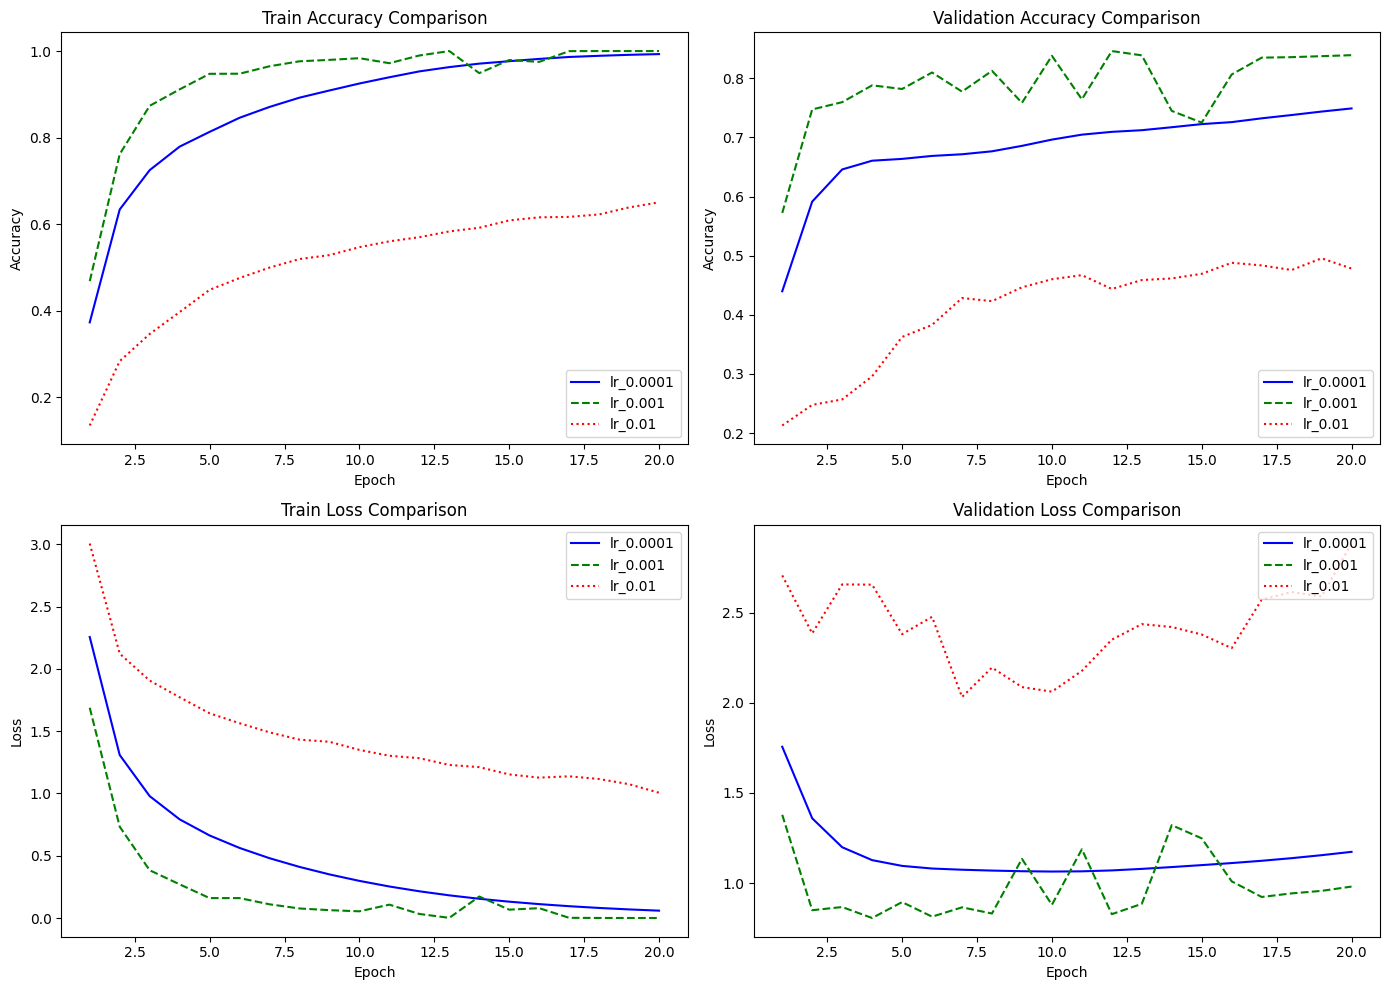

In [98]:
from tensorflow.keras.optimizers import Adam

# Different learning rates to evaluate
initial_learning_rates = [0.0001, 0.001, 0.01]

# Dictionary to store training results keyed by learning rate
training_results = {}

# Test each learning rate for its impact on model performance
for learning_rate in initial_learning_rates:
    set_seed(42)  # Set a seed for reproducibility

    # Construct the model using SELU activation
    neural_model = build_custom_dnn([256, 128], activation_type="elu")
    
    # Configure the optimizer with the current learning rate
    custom_optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the specified optimizer
    neural_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and capture the training history
    model_history = neural_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val)
    )
    
    # Record the history for this learning rate
    training_results[f"lr_{learning_rate}"] = model_history

# Plot the performance
plot_model_comparison(training_results)


**Observations:**

***Train Accuracy:***

- Learning Rate 0.001: This learning rate achieved the highest training accuracy and converged quickly, maintaining nearly perfect accuracy throughout the training process.
  
- Learning Rate 0.0001: This rate also achieved high training accuracy but took more epochs to converge compared to 0.001.

- Learning Rate 0.01: This rate underperformed significantly, with the model failing to learn effectively, as indicated by the very low training accuracy.

***Validation Accuracy:***

- Learning Rate 0.001: This rate consistently achieved the highest validation accuracy, showing good generalization to unseen data.
  
- Learning Rate 0.0001: This rate showed stable validation accuracy but was consistently lower than 0.001.
  
- Learning Rate 0.01: This rate performed the worst in validation accuracy, indicating poor generalization, likely due to the model struggling to learn effectively.

***Train Loss:***

- Learning Rate 0.001: The loss decreased rapidly and stabilized at a low value, consistent with its high training accuracy.

- Learning Rate 0.0001: The loss decreased more gradually, reflecting the slower learning process.

- Learning Rate 0.01: The loss remained high throughout the training, indicating that the model was not effectively minimizing the loss function.

***Validation Loss:***

- Learning Rate 0.001: This rate had the lowest and most stable validation loss, suggesting it generalizes well.

- Learning Rate 0.0001: The validation loss was higher than for 0.001, indicating less effective generalization.

- Learning Rate 0.01: The validation loss was the highest and most unstable, further confirming poor performance.

***Conclusion:***

**The 0.001 learning rate is the most optimal choice based on the provided metrics.** It achieved the highest validation accuracy and the lowest validation loss, with the most stable performance across all metrics.

#### **DNN Optimizer Optimization**

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3140 - loss: 2.2874 - val_accuracy: 0.5563 - val_loss: 1.3397
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7194 - loss: 0.8502 - val_accuracy: 0.7111 - val_loss: 0.9447
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8536 - loss: 0.4460 - val_accuracy: 0.7699 - val_loss: 0.7767
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9249 - loss: 0.2383 - val_accuracy: 0.7830 - val_loss: 0.8413
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9529 - loss: 0.1472 - val_accuracy: 0.7713 - val_loss: 0.9688
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9628 - loss: 0.1158 - val_accuracy: 0.7535 - val_loss: 1.0668
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9671 - loss: 0.0994 - val_accuracy: 0.7139 - val_loss: 1.3787
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9551 - loss: 0.1373 - val_accuracy: 0.8299 - val_

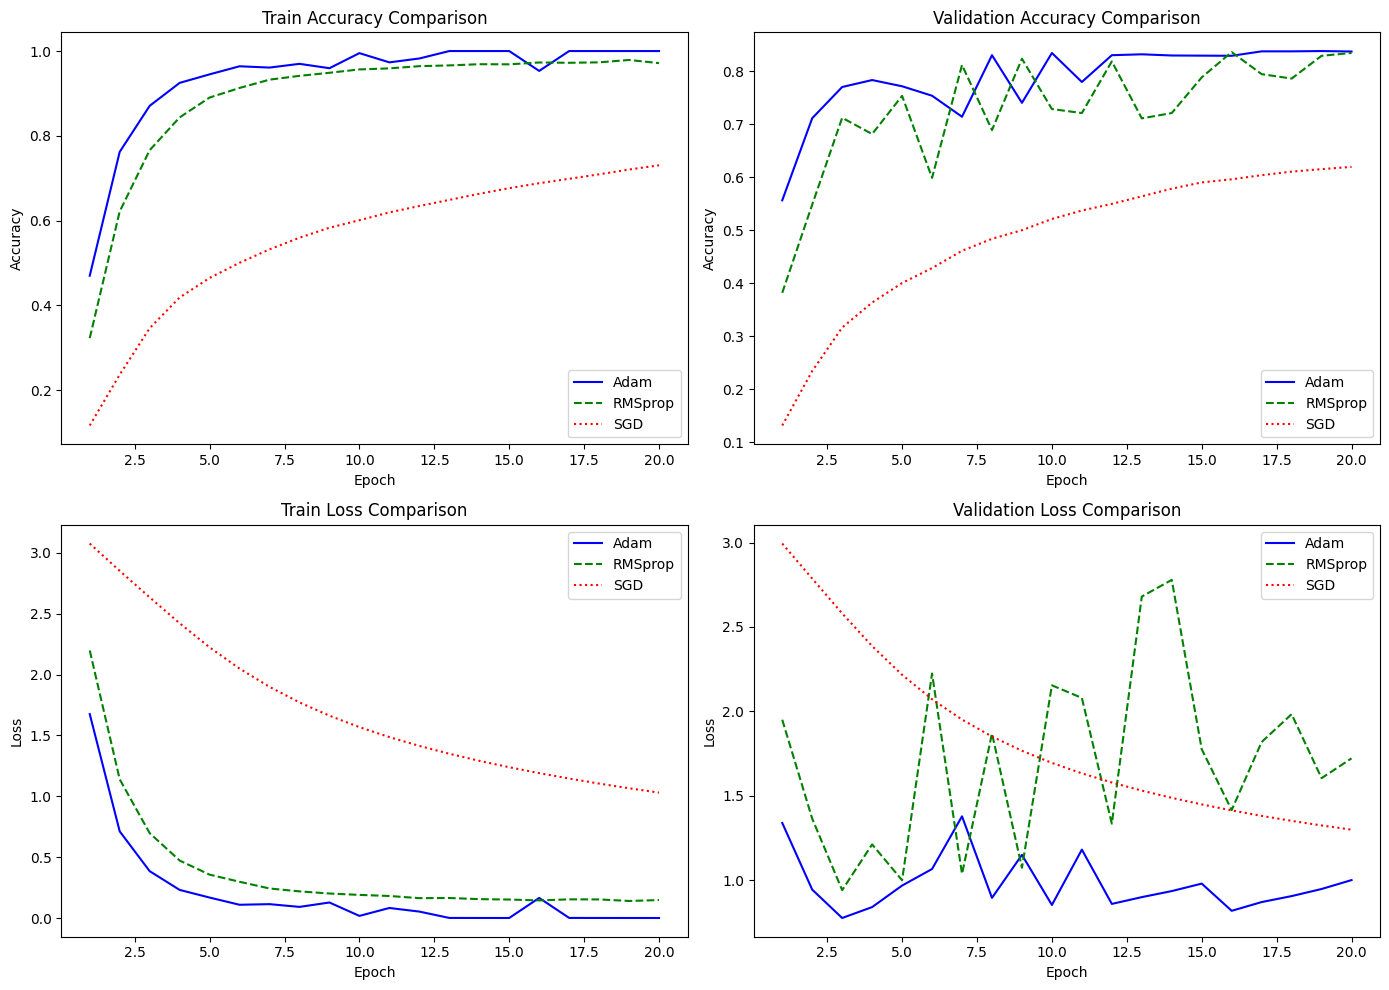

In [69]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Dictionary to collect training histories for various optimizers
optimizer_histories = {}

# Selection of optimizers to evaluate their effectiveness
selected_optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "RMSprop": RMSprop(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.001)
}

# Evaluate each optimizer by training a model with it
for optimizer_name, opt in selected_optimizers.items():
    set_seed(42)  # Ensure consistent initialization

    # Build and compile a neural network with the SELU activation function
    neural_net = build_custom_dnn([256, 128], activation_type="elu")
    neural_net.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Execute training
    training_session = neural_net.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
    
    # Log the training history keyed by the optimizer name
    optimizer_histories[optimizer_name] = training_session

# Plot the performance
plot_model_comparison(optimizer_histories)


**Observations:**

***Train Accuracy:***

- Adam: This optimizer achieved the highest training accuracy, quickly converging to nearly perfect accuracy.

- RMSprop: Also achieved high training accuracy, but slightly lower than Adam.

- SGD: Showed the lowest training accuracy, with a much slower learning curve compared to Adam and RMSprop.

***Validation Accuracy:***

- Adam: Consistently achieved the highest validation accuracy, indicating strong generalization to unseen data.

- RMSprop: Also performed well, but with more fluctuations in validation accuracy and slightly lower peak values than Adam.

- SGD: Underperformed significantly in validation accuracy, showing a much slower increase and lower peak accuracy compared to Adam and RMSprop.

***Train Loss:***

- Adam: The loss decreased rapidly and stabilized at a very low value, reflecting its high training accuracy.

- RMSprop: Also showed a good reduction in loss, though slightly less effective than Adam.

- SGD: The loss remained much higher throughout the training, consistent with its slower learning and lower accuracy.

***Validation Loss:***

- Adam: Had the lowest and most stable validation loss, indicating strong generalization and minimal overfitting.

- RMSprop: Showed more fluctuations in validation loss, with occasional spikes, indicating less stable performance.

- SGD: The validation loss was the highest and least stable, consistent with its poorer performance overall.

***Conclusion:***

**The Adam optimizer is the most optimal choice based on the provided metrics.** It achieved the highest validation accuracy, the lowest validation loss, and exhibited the most stable performance across the board.

#### **DNN Kernel Initializer Optimization**

Since `Elu` is being selected, we can try `HeNormal` and `RandomNormal` since they are compatible. We alos include the trial of `LecunNormal`

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3124 - loss: 2.3429 - val_accuracy: 0.5848 - val_loss: 1.3240
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7151 - loss: 0.8620 - val_accuracy: 0.7078 - val_loss: 0.9209
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8439 - loss: 0.4656 - val_accuracy: 0.7351 - val_loss: 0.8816
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9091 - loss: 0.2760 - val_accuracy: 0.7730 - val_loss: 0.8726
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9486 - loss: 0.1592 - val_accuracy: 0.7663 - val_loss: 0.9943
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.1070 - val_accuracy: 0.7493 - val_loss: 1.1423
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9661 - loss: 0.1033 - val_accuracy: 0.8173 - val_loss: 0.8654
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9706 - loss: 0.0935 - val_accuracy: 0.8427 - val_

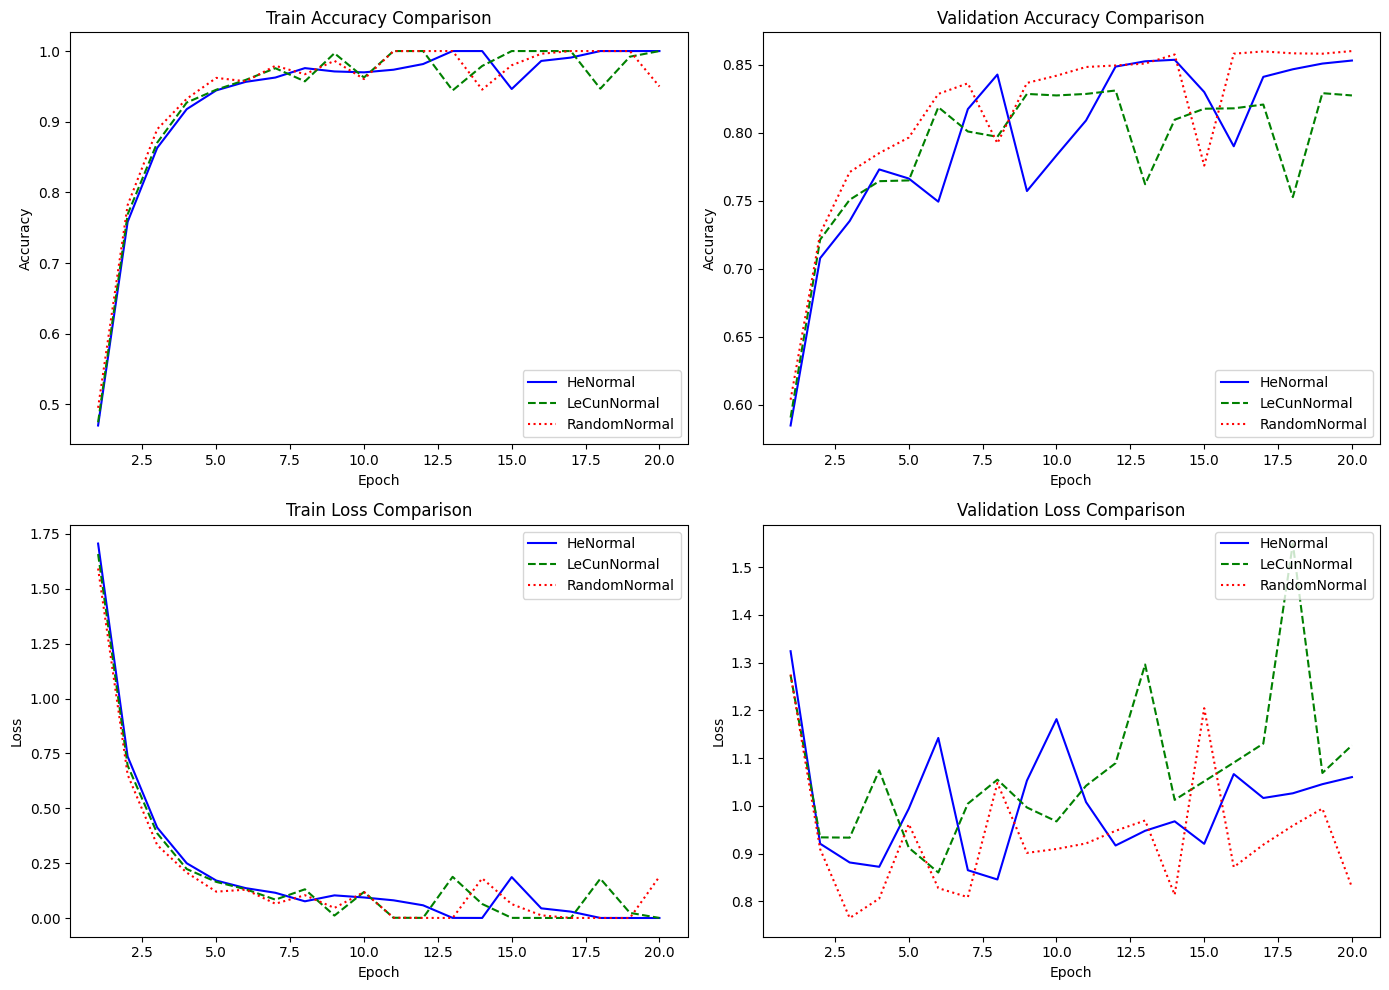

In [71]:
from tensorflow.keras.initializers import HeNormal, LecunNormal, RandomNormal

# Define various initializers to test their impact on model performance
initializers_to_test = {
    "HeNormal": HeNormal(),
    "LeCunNormal":LecunNormal(),
    "RandomNormal": RandomNormal()
}

# Dictionary to store training histories for different initializers
training_histories_by_initializer = {}

# Iterating over each weight initializer configuration
for initializer_name, weight_initializer in initializers_to_test.items():
    set_seed(42)  # Ensuring consistent random seed for reproducibility

    # Constructing the model with ELU activation and specified initializer
    model = build_custom_dnn([256, 128], activation_type="elu", initializer=weight_initializer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Executing the model training
    training_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
    
    # Storing the training results for later comparison
    training_histories_by_initializer[initializer_name] = training_history

# Plot the performance
plot_model_comparison(training_histories_by_initializer)


**Observations:**

***Train Accuracy:***

All three initializers (HeNormal, LeCunNormal, RandomNormal) performed similarly in terms of training accuracy. They all converged to almost perfect accuracy by the end of the training epochs.

***Validation Accuracy:***

- RandomNormal: Showed slightly higher validation accuracy at certain points and generally had less fluctuation in performance, suggesting a more stable model.
  
- LeCunNormal: Also performed well with slight fluctuations, particularly between epochs 10 to 15.
  
- HeNormal: While also showing good validation accuracy, it had a bit more fluctuation compared to RandomNormal.

***Train Loss:***

- The loss for all initializers decreased rapidly and stabilized at very low values, consistent with the high training accuracy observed.

- The differences in training loss among the initializers were negligible, indicating all initializers facilitated good convergence during training.

***Validation Loss:***

- RandomNormal: Showed the most consistent and generally lower validation loss, which suggests better generalization and less overfitting.

- HeNormal and LeCunNormal: Both had more fluctuations in validation loss, with occasional spikes, indicating slightly less stability compared to RandomNormal.

***Conclusion:***

**The RandomNormal initializer appears to be the most optimal choice based on the provided metrics.** It exhibited slightly better and more consistent validation accuracy and lower validation loss, indicating better generalization performance and stability.

#### **DNN Regularization**

Here, we will test different extents of L2 Regularizer

In [75]:
from tensorflow.keras import regularizers

# Function to build a model with specified regularization
def build_regularized_model(layer_sizes, regularization_factor=0.01):
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 1), name='input_flatten'))
    
    # Adding layers with ELU activation and RandomNormal initialization
    for index, size in enumerate(layer_sizes):
        model.add(Dense(
            size, 
            activation='elu', 
            kernel_initializer=RandomNormal(),  # Using RandomNormal initializer
            kernel_regularizer=regularizers.l2(regularization_factor),  # Applying L2 regularization
            name=f'layer_{index + 1}'
        ))
    
    model.add(Dense(24, activation='softmax', kernel_initializer=RandomNormal(), name='output_layer'))
    
    return model


Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0598 - loss: 13.6738 - val_accuracy: 0.0742 - val_loss: 3.1520
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1075 - loss: 3.0151 - val_accuracy: 0.1180 - val_loss: 3.0586
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1286 - loss: 2.8910 - val_accuracy: 0.1316 - val_loss: 2.9324
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1585 - loss: 2.8282 - val_accuracy: 0.1266 - val_loss: 3.2045
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1941 - loss: 2.7085 - val_accuracy: 0.1266 - val_loss: 3.1913
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2126 - loss: 2.6193 - val_accuracy: 0.2091 - val_loss: 2.7569
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2293 - loss: 2.5756 - val_accuracy: 0.2050 - val_loss: 2.6611
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2459 - loss: 2.5190 - val_accuracy: 0

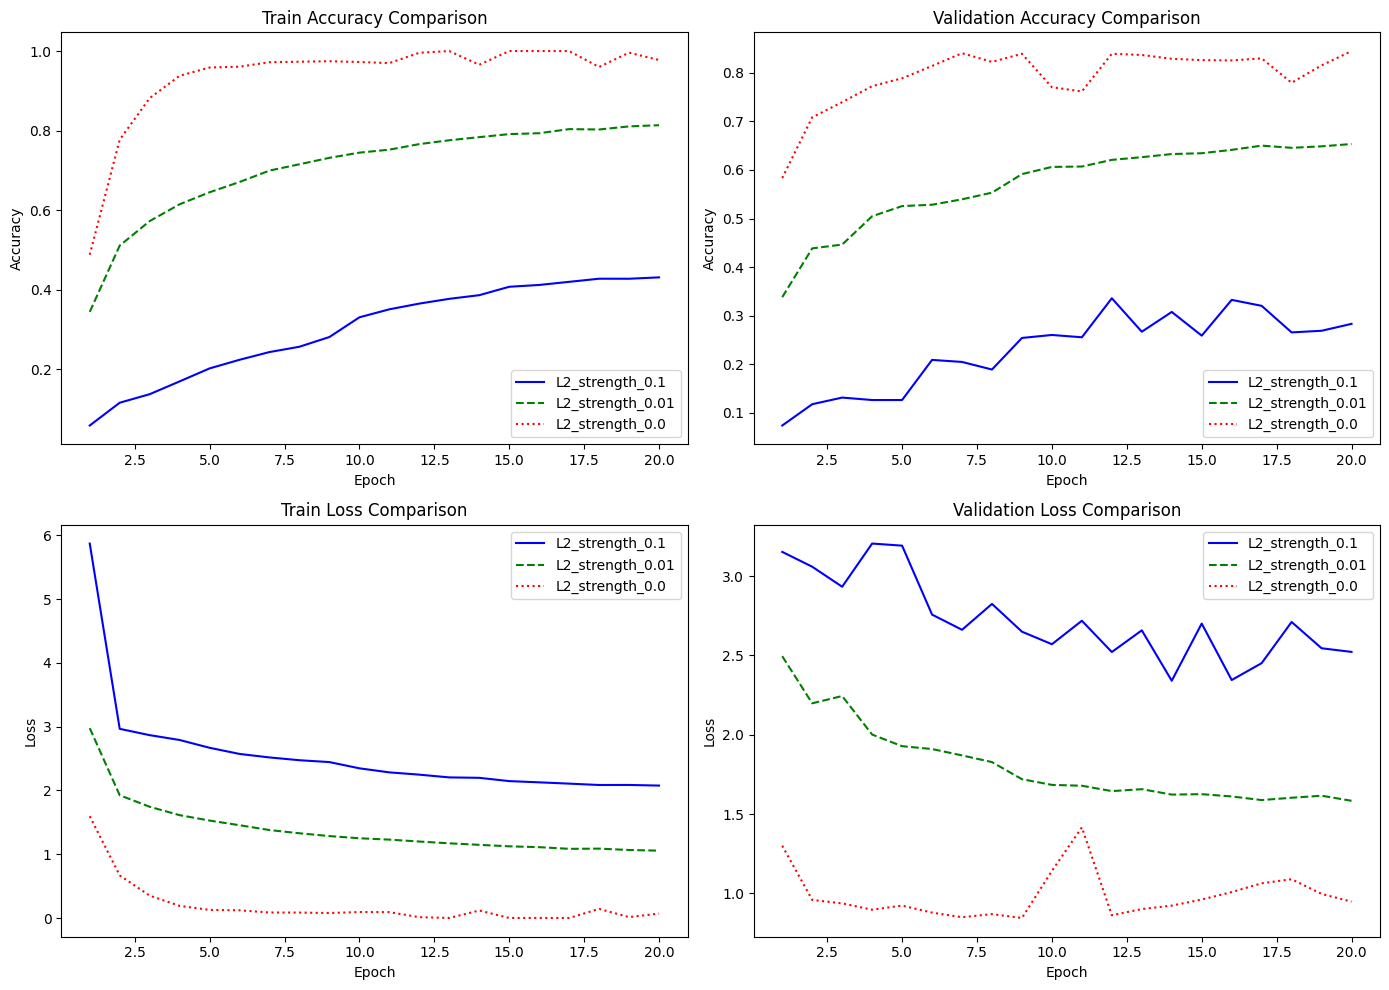

In [99]:
# Dictionary to store training outcomes
model_histories = {}

# Different levels of L2 regularization to test
regularization_levels = [0.1, 0.01, 0.0]  # Strong, mild and no regularization

# Evaluate the impact of each level of L2 regularization
for regularization_strength in regularization_levels:
    set_seed(42)  # Ensure reproducibility

    # Create, compile, and train the model
    neural_network = build_regularized_model([256, 128], regularization_factor=regularization_strength)
    neural_network.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    training_process = neural_network.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),verbose=1)
    
    # Log training history
    model_histories[f"L2_strength_{regularization_strength}"] = training_process

# Plot the performance
plot_model_comparison(model_histories)

**Observations:**

***Train Accuracy:***

- L2_strength_0.0 (No regularization) achieved the highest training accuracy, approaching 100% by the end of training

- L2_strength_0.01 (Mild regularization) had a balanced increase in training accuracy, reaching around 70%–80% by the end of training.

- L2_strength_0.1 (Strong regularization) had the lowest training accuracy, indicating that strong regularization limited the model's ability to fit the training data well.

***Validation Accuracy:***

- L2_strength_0.0 (No regularization) consistently achieved the highest validation accuracy, suggesting the model generalized well despite the lack of regularization.

- L2_strength_0.01 (Mild regularization) also showed good validation accuracy but was slightly lower than the model without regularization.

- L2_strength_0.1 (Strong regularization) had the lowest validation accuracy, which aligns with its lower training accuracy.

***Train Loss:***

- L2_strength_0.0 (No regularization) showed the lowest training loss, which is expected given its high training accuracy.

- L2_strength_0.01 (Mild regularization) had higher training loss than the model without regularization but lower than the model with strong regularization.

- L2_strength_0.1 (Strong regularization) had the highest training loss, indicating that the model struggled to fit the training data due to the regularization.

***Validation Loss:***

- L2_strength_0.0 (No regularization) achieved the lowest validation loss, supporting the observation that it generalized well.

- L2_strength_0.01 (Mild regularization) showed a moderate validation loss, higher than the model without regularization.

- L2_strength_0.1 (Strong regularization) had the highest and most fluctuating validation loss, further indicating poor generalization.

***Conclusion:***

**The L2_strength_0.0 (No regularization) model appears to be the most optimal choice based on the provided metrics.** It achieved the highest validation accuracy and the lowest validation loss, indicating good generalization despite not using regularization.

#### **DNN Reduce Learning Rate - Early Stopping**

Epoch 1/50


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


858/858 - 2s - 2ms/step - accuracy: 0.4924 - loss: 1.5921 - val_accuracy: 0.5809 - val_loss: 1.3272 - learning_rate: 0.0010
Epoch 2/50
858/858 - 1s - 2ms/step - accuracy: 0.7737 - loss: 0.6709 - val_accuracy: 0.7192 - val_loss: 0.8820 - learning_rate: 0.0010
Epoch 3/50
858/858 - 1s - 2ms/step - accuracy: 0.8770 - loss: 0.3626 - val_accuracy: 0.7479 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 4/50
858/858 - 1s - 2ms/step - accuracy: 0.9287 - loss: 0.2162 - val_accuracy: 0.7995 - val_loss: 0.7755 - learning_rate: 0.0010
Epoch 5/50
858/858 - 2s - 2ms/step - accuracy: 0.9576 - loss: 0.1318 - val_accuracy: 0.8070 - val_loss: 0.7685 - learning_rate: 0.0010
Epoch 6/50
858/858 - 2s - 2ms/step - accuracy: 0.9617 - loss: 0.1194 - val_accuracy: 0.7607 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 7/50
858/858 - 2s - 2ms/step - accuracy: 0.9671 - loss: 0.1052 - val_accuracy: 0.8162 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 8/50
858/858 - 2s - 2ms/step - accuracy: 0.9633 - loss: 0.11

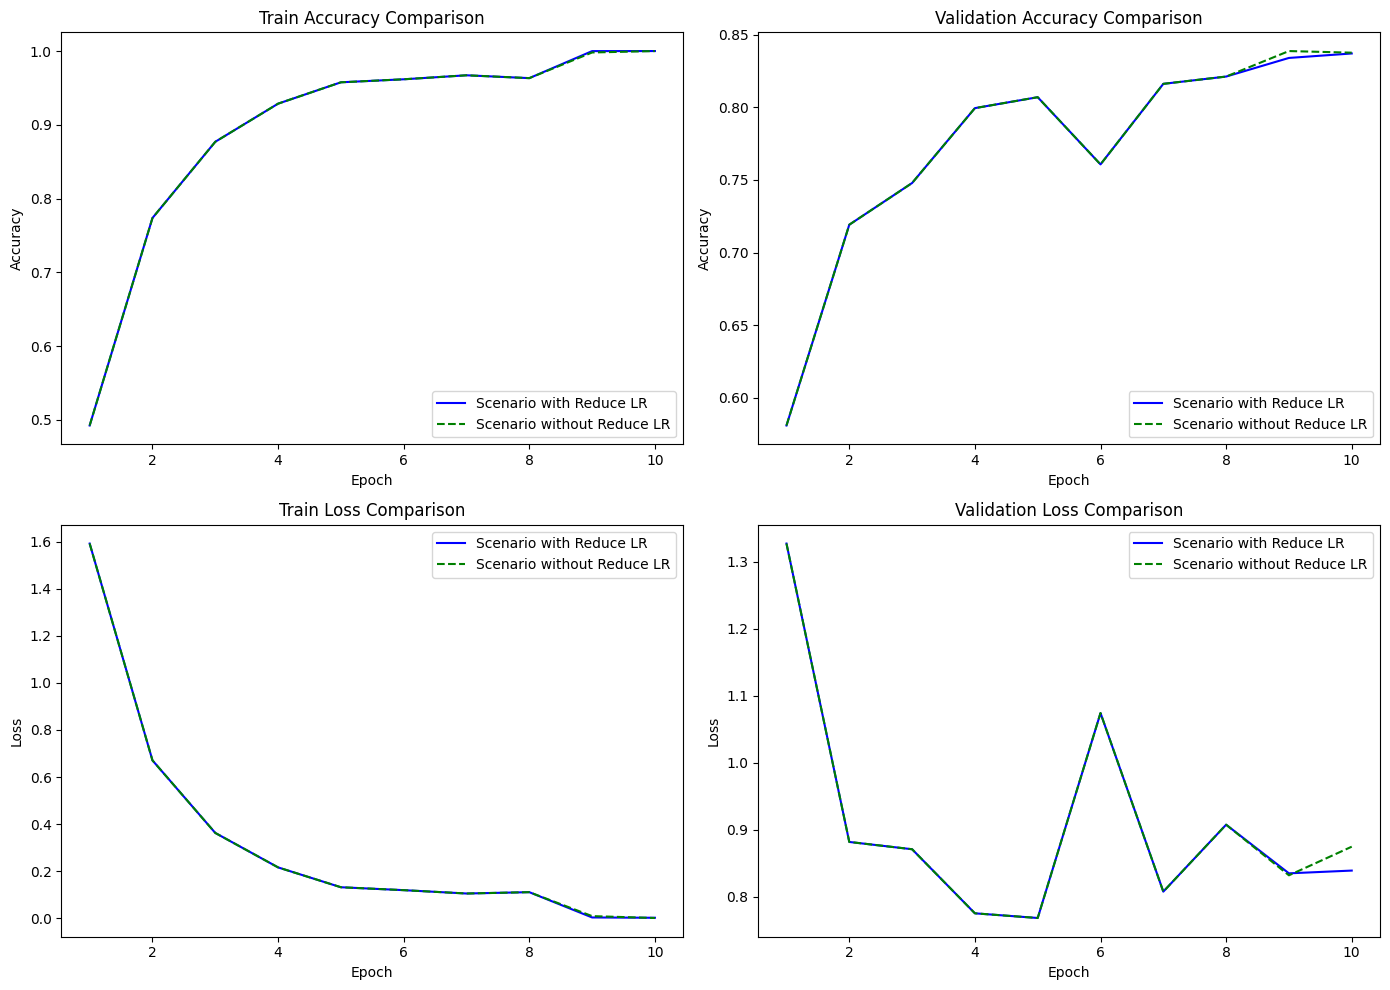

In [100]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Store histories for comparison
callback_histories = {}

# Define reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# List of callback scenarios to test
cases = {
    "Scenario with Reduce LR": [reduce_lr],
    "Scenario without Reduce LR": []
}


# Loop through each callback scenario
for case, callbacks in cases.items():
    set_seed(42)
    
    model = build_custom_dnn([258, 128], activation_type="elu", initializer=RandomNormal())
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model with the current callbacks scenario
    training_history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=callbacks + [early_stopping],
        verbose=2
    )
    
    # Store history
    callback_histories[case] = training_history

# Plot the performance
plot_model_comparison(callback_histories)


**Observations:**

**Training Accuracy and Loss:**

Both scenarios start with similar training accuracy and loss.

Over the epochs, the model with Reduce LR shows a more stable and gradual improvement, particularly after the learning rate is reduced, leading to very high training accuracy (approaching 100%) and low loss.

***Validation Accuracy and Loss:***

Initially, both scenarios show similar validation accuracy and loss.

As training progresses, the scenario with Reduce LR maintains or slightly improves validation accuracy while effectively reducing validation loss after the learning rate drops.

The model without Reduce LR achieves high validation accuracy but with more fluctuation in validation loss, indicating potential instability or overfitting.

***Learning Rate Adjustment:***

In the Reduce LR scenario, the learning rate drops by a factor of 0.2 after validation loss stops improving for three consecutive epochs, leading to a significant drop in validation loss, which can be crucial for fine-tuning the model's performance.

Without Reduce LR, the learning rate remains constant, which might prevent the model from reaching an optimal minimum in the loss landscape.

***Conclusion:***

**The Scenario with Reduce Learning Rate on Plateau (Reduce LR) is the more optimal approach based on the analysis.** It demonstrates better handling of validation loss, achieving comparable or better validation accuracy with a more stable and lower loss. This method effectively fine-tunes the model's learning process by adjusting the learning rate based on validation performance, leading to potentially better generalization.

To sum up, we have experiements on:
- Architecture: 3 different artitectures from 1 to 3 hidden layers, with the best one is **[256,128]** (3 times running)
- Activation Function: **Elu**, Selu, Relu (3 times running)
- Learning rate: 0.1, **0.001**, 0.0001 (3 times running)
- Optimizers: RMSProp, SGD and **Adam** (3 times running)
- Kernel Initialization: HeNormal, LecunNormal, **RandomNormal** (3 times running)
- L2 Regularizers: 0.1, 0.01, **0.0** (3 times running)
- Earrly Stopping - LR Reduction: **Yes**, No (2 times running)

The bold one is the chosen candidate after each time optimzing

The total running times = 20 

Since we have the CNN optimization, we can create the function calling out the most well-perorming model in DNN as follows:

In [128]:
# Define the top-performing DNN model
def build_optimal_dnn():
    # Set the random seed for reproducibility
    set_seed(42)

    # Initialize and compile the DNN model
    dnn_model = build_custom_dnn(neuron_list=[256, 128], activation_type="elu", initializer=RandomNormal())
    dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up callbacks
    stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
    
    # Train the model with the defined callbacks
    training_history = dnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
        callbacks=[stop_early, lr_scheduler],
        verbose=1
    )

    return dnn_model, training_history

### **CNN Optimzation**


As in the experiemnts with DNN, we can implement trials on:

- Architecture
- Activation Function
- Learning Rate
- Optimizer
- Kernel Initializer
- Regularization

However, we can optize the model with trial of BatchNormalization

First, we create a function for CNN to tailor the hyperparameters passed later on

In [108]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


def create_custom_cnn(filters, dense_layers, activation='elu', kernel_initializer=RandomNormal()):
    network = Sequential()
    
    # Input layer 
    network.add(Conv2D(filters[0], (3, 3), activation=activation, input_shape=(32, 32, 1), kernel_initializer= kernel_initializer, name='conv_1'))
    network.add(MaxPooling2D((2, 2), name = 'max_pool_1'))
    
    # Additional convolutional layers 
    for i in range(1, len(filters)):
        network.add(Conv2D(filters[i], (3, 3), activation=activation, kernel_initializer=kernel_initializer, name=f'conv_{i+1}'))
        network.add(MaxPooling2D((2, 2), name=f'max_pool_{i+1}'))
        
    
    # Flatten and dense layers with Dropout
    network.add(Flatten(name='flatten'))
    for i, units in enumerate(dense_layers):
        network.add(Dense(units, activation=activation, kernel_initializer=kernel_initializer, name=f'dense_{i+1}'))
        
    
    network.add(Dense(24, activation='softmax', kernel_initializer=kernel_initializer, name='output'))
    
    return network


#### **CNN Architecture Optimzation**

There are three trials on `{'filters': [32, 64, 128], 'dense_layers': [256]},`, `{'filters': [48, 96, 192], 'dense_layers': [256]}`, `{'filters': [24, 48, 96], 'dense_layers': [256]}` with the number of params as 230168, 411160, 156952 respectively.

All are less than 500000 parameters so we can staisfy the requirement


CNN Config 1: Parameter count: 230168
Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6367 - loss: 1.2094 - val_accuracy: 0.9194 - val_loss: 0.3182
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9989 - loss: 0.0084 - val_accuracy: 0.9264 - val_loss: 0.2869
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9989 - loss: 0.0051 - val_accuracy: 0.9476 - val_loss: 0.2418
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 2.5126e-04 - val_accuracy: 0.9484 - val_loss: 0.2522
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 1.0479e-04 - val_accuracy: 0.9498 - val_loss: 0.2651
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 5.6178e-05 - val_accuracy: 0.9506 - val_loss: 0.2780
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 3.1916e-05 - val_accuracy: 0.9515 - val_loss: 0.2909
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/ste

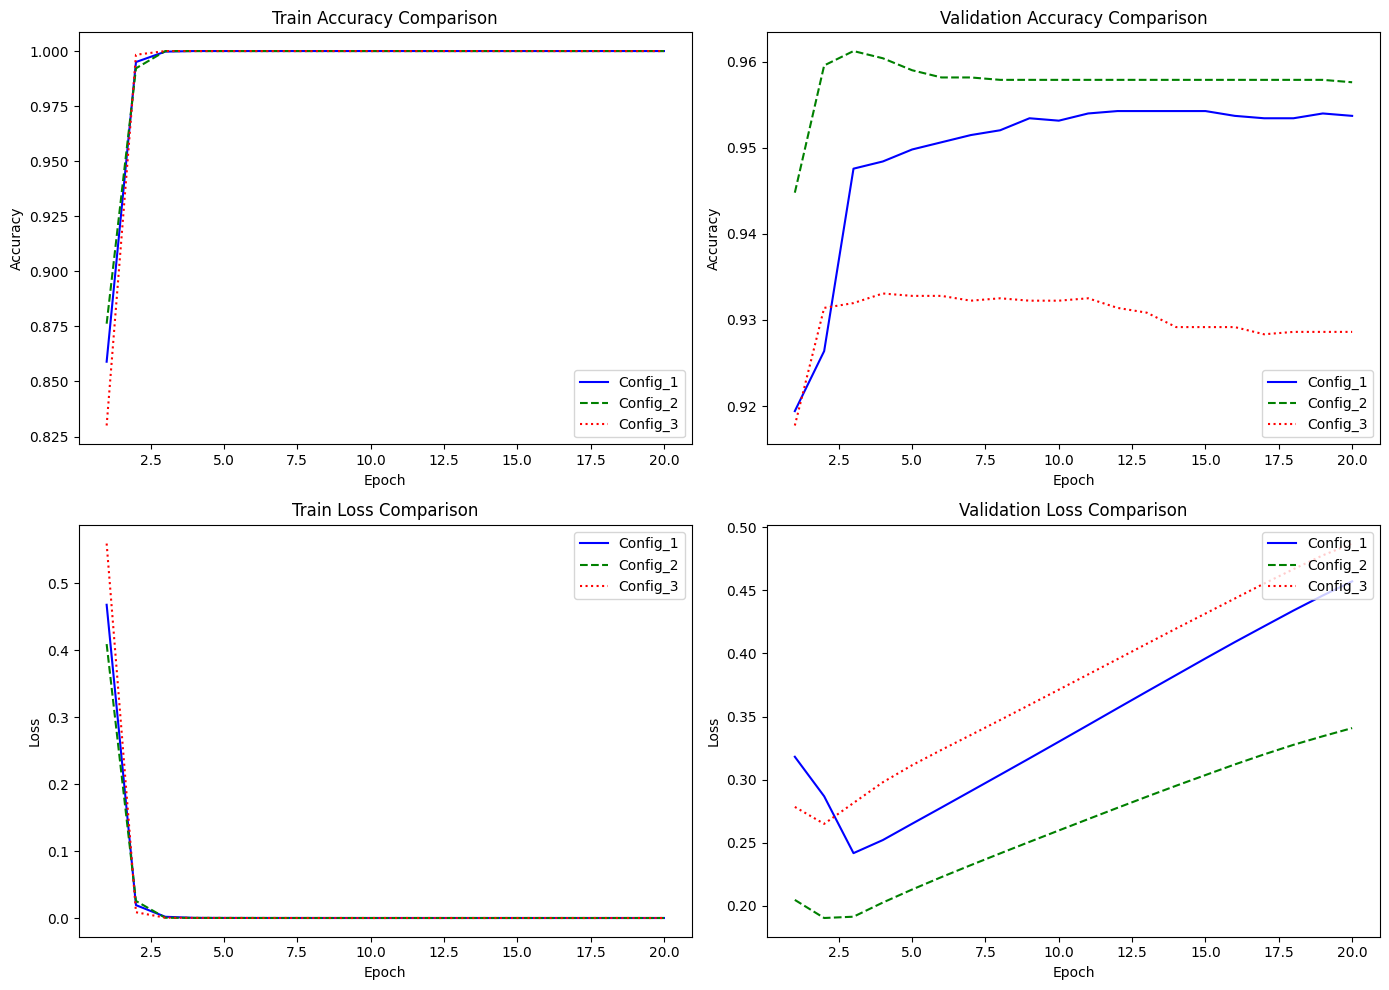

In [110]:
# Various CNN configurations to explore
cnn_configs = [
    {'filters': [32, 64, 128], 'dense_layers': [256]},
    {'filters': [48, 96, 192], 'dense_layers': [256]},
    {'filters': [24, 48, 96], 'dense_layers': [256]},
]

# Dictionary to keep track of training histories for each configuration
training_histories = {}

# Iterating through each CNN configuration
for config_index, cnn_config in enumerate(cnn_configs, start=1):
    # Build the CNN model with specified configuration
    cnn_model = create_custom_cnn(
        filters=cnn_config['filters'],
        dense_layers=cnn_config['dense_layers']
    )
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display total number of parameters in the model
    print(f"CNN Config {config_index}: Parameter count: {cnn_model.count_params()}")

    # Training the model with the defined callbacks
    training_log = cnn_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Save the training history for this configuration
    training_histories[f"Config_{config_index}"] = training_log

# Plot the performance
plot_model_comparison(training_histories)

**Analysis:**

***Training Accuracy & Loss:***

All configurations achieve near-perfect training accuracy, indicating that all models are sufficiently complex to learn from the training data.

The training loss for all configurations decreases quickly and remains low throughout, suggesting that the models are not underfitting.


***Validation Accuracy:***

Config 2 has the highest validation accuracy, reaching around 96%. This suggests that it generalizes the best on unseen data.

Config 1 also performs well, with a slightly lower validation accuracy (around 95.5%).

Config 3 has the lowest validation accuracy, stabilizing around 92%, indicating that it is not performing as well on unseen data compared to the other two configurations.

***Validation Loss:***

Config 2 has the lowest validation loss, which aligns with its higher validation accuracy. This suggests that it is less likely to overfit compared to the other configurations.

Config 1 has slightly higher validation loss than Config 2, but still performs well.

Config 3 has the highest validation loss, correlating with its lower validation accuracy.

***Conclusion:***

**Config 2 (Filters: [48, 96, 192], Dense Layers: [256]) is the most optimal model among the three configurations.** It has the best validation accuracy and the lowest validation loss, indicating that it generalizes well to new data and is less prone to overfitting.

#### **CNN Activation Function Optimzation**

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6652 - loss: 1.1169 - val_accuracy: 0.9448 - val_loss: 0.2048
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 0.9596 - val_loss: 0.1905
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 4.8212e-04 - val_accuracy: 0.9612 - val_loss: 0.1915
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.4140e-04 - val_accuracy: 0.9604 - val_loss: 0.2027
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 6.7938e-05 - val_accuracy: 0.9590 - val_loss: 0.2130
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 3.6729e-05 - val_accuracy: 0.9582 - val_loss: 0.2229
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 2.1027e-05 - val_accuracy: 0.9582 - val_loss: 0.2323
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.2420e-05 - val

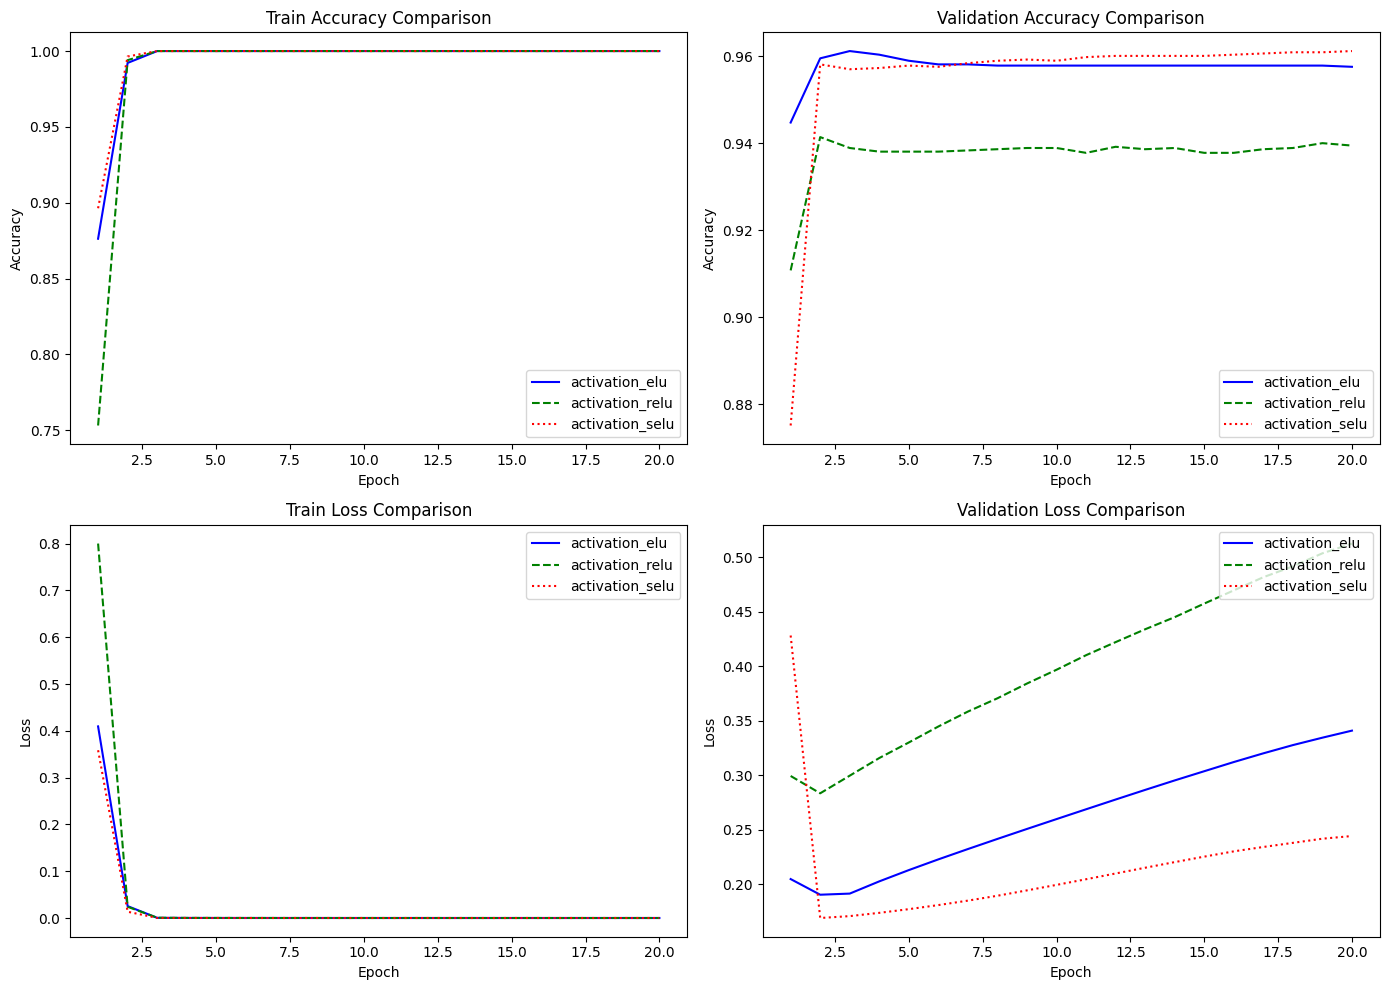

In [112]:
# Define a list of activation functions to evaluate
activation_functions = ['elu', 'relu', 'selu']

# Dictionary to hold the training logs for comparison
activation_logs = {}

# Iterate over each activation function
for activation_fn in activation_functions:
    set_seed(42)  # Ensuring reproducibility
    
    # Build the CNN model with the current activation function
    cnn_model = create_custom_cnn(
        filters=[48, 96, 192],
        dense_layers=[256],
        activation=activation_fn
    )
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and save the history
    training_record = cnn_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
    )
    
    # Store the training history with the activation function as the key
    activation_logs[f"activation_{activation_fn}"] = training_record

# Plot the performance
plot_model_comparison(activation_logs)


**Key Observations:**

***Training Accuracy & Loss:***

All activation functions achieved near-perfect training accuracy (close to 100%) by the end of the training process.

The training loss is almost zero across all activation functions, indicating that the models are sufficiently complex to fit the training data.

***Validation Accuracy:***

SELU (red dotted line) and ELU (solid blue line) have the highest and most stable validation accuracy. SELU slightly edges out ELU, maintaining higher validation accuracy throughout the epochs.

ReLU (green dashed line) performs the worst among the three, with noticeably lower validation accuracy that doesn't improve significantly over the epochs.

***Validation Loss:***

SELU and ELU also have the lowest validation loss, with SELU performing marginally better. This indicates better generalization to unseen data.

ReLU has a higher and more inconsistent validation loss, which aligns with its lower validation accuracy.

***Conclusion:***

**SELU is the most optimal activation function among the three.** It achieved the highest and most stable validation accuracy, and the lowest validation loss, suggesting it generalizes better on the validation set compared to ELU and ReLU.

ELU is a close second, performing almost as well as SELU, and would be a reasonable alternative.

#### **CNN Learning Rate Optimzation**

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3457 - loss: 2.3673 - val_accuracy: 0.7878 - val_loss: 0.7544
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9018 - loss: 0.4187 - val_accuracy: 0.8949 - val_loss: 0.3666
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9884 - loss: 0.1167 - val_accuracy: 0.9161 - val_loss: 0.2657
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9993 - loss: 0.0368 - val_accuracy: 0.9289 - val_loss: 0.2320
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9375 - val_loss: 0.2199
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9400 - val_loss: 0.2151
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9420 - val_loss: 0.2153
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.

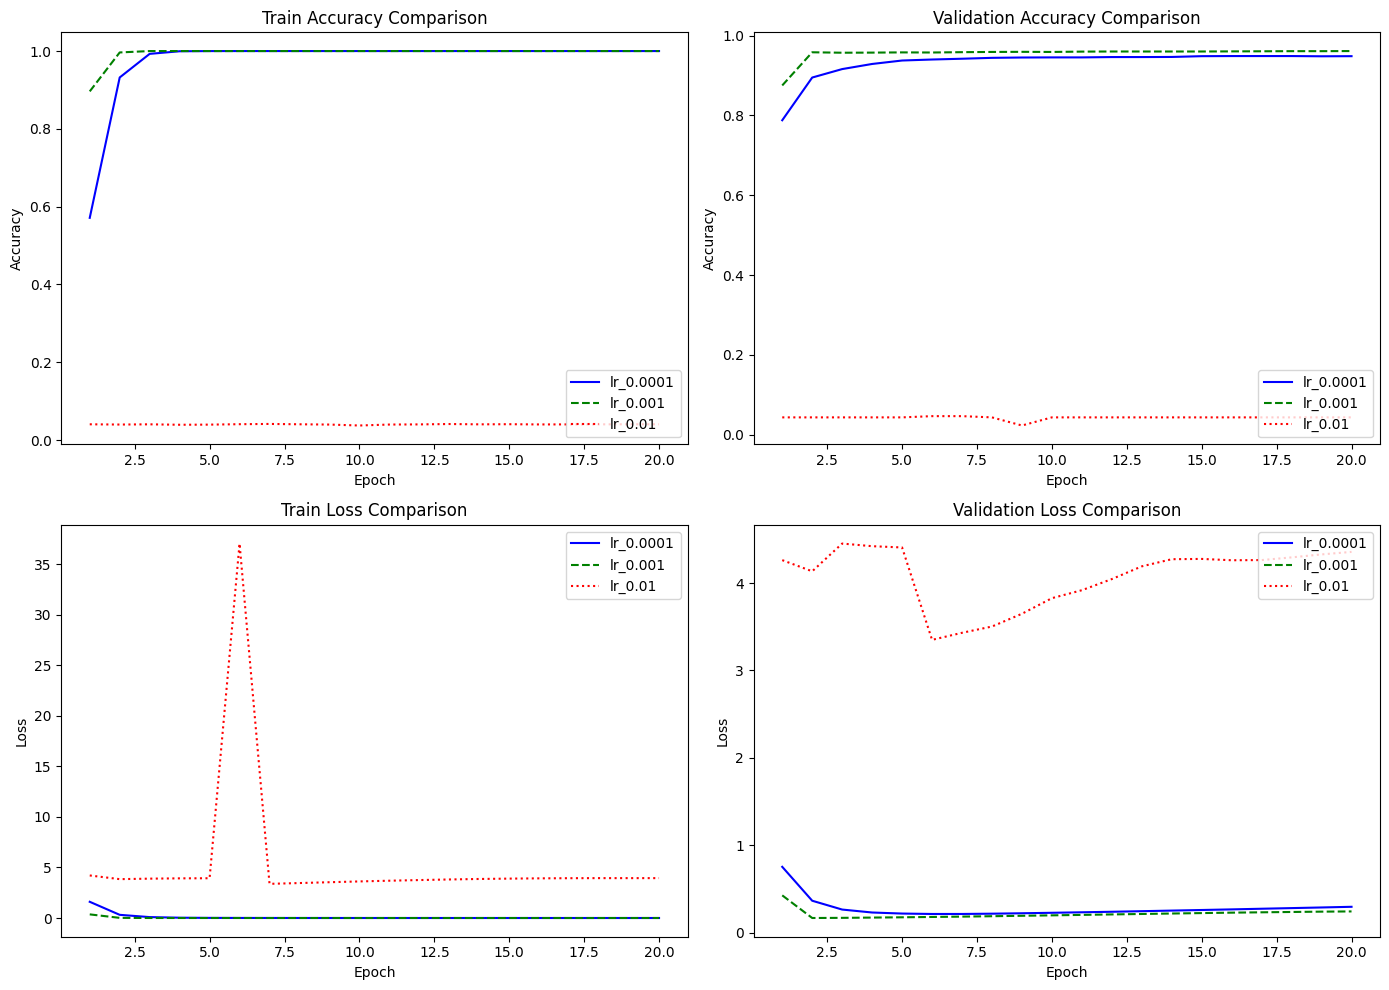

In [115]:
# Dictionary to hold the training histories for each learning rate
lr_training_results = {}

# Define various initial learning rates to experiment with
init_lr_values = [0.0001, 0.001, 0.01]

# Iterate over each specified learning rate
for lr_value in init_lr_values:
    # Ensure reproducibility by setting a seed
    set_seed(42)
    
    # Construct the CNN model with the given parameters
    cnn_model = create_custom_cnn(
        filters=[48, 96, 192],
        dense_layers=[256],
        activation="selu"
    )
    
    # Compile the model with the current learning rate
    cnn_model.compile(optimizer=Adam(learning_rate=lr_value), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and capture the training history
    train_history = cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),)
    
    # Save the training history in the dictionary with the learning rate as the key
    lr_training_results[f"lr_{lr_value}"] = train_history

# Plot the performance
plot_model_comparison(lr_training_results)

**Analysis of Learning Rates**

Based on the plots and the provided logs:

***Learning Rate 0.0001:***

Accuracy: Consistently high, achieving nearly perfect accuracy on both training and validation sets.

Loss: Stable and low loss across training and validation, indicating effective learning without overfitting.

***Learning Rate 0.001:***

Accuracy: Also shows high accuracy similar to the 0.0001 learning rate, but with slightly faster convergence.

Loss: Similarly low and stable, indicating this learning rate is optimal for fast convergence while maintaining accuracy.

***Learning Rate 0.01:***

Accuracy: Extremely poor performance with almost no learning observed. The model struggles, indicating the learning rate is too high.

Loss: Very high and unstable, confirming that this learning rate is inappropriate for this model.

***Optimal Choice***

**The learning rate 0.001 is the optimal choice** as it provides a good balance of fast convergence and high accuracy without instability.

#### **CNN Optimizer Optimzation**

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7057 - loss: 1.0204 - val_accuracy: 0.8751 - val_loss: 0.4281
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9908 - loss: 0.0322 - val_accuracy: 0.9582 - val_loss: 0.1691
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.7546e-04 - val_accuracy: 0.9571 - val_loss: 0.1708
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 8.0614e-05 - val_accuracy: 0.9573 - val_loss: 0.1738
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 4.4503e-05 - val_accuracy: 0.9579 - val_loss: 0.1772
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 2.6140e-05 - val_accuracy: 0.9576 - val_loss: 0.1809
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.5845e-05 - val_accuracy: 0.9584 - val_loss: 0.1850
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 9.7615e-06 - val

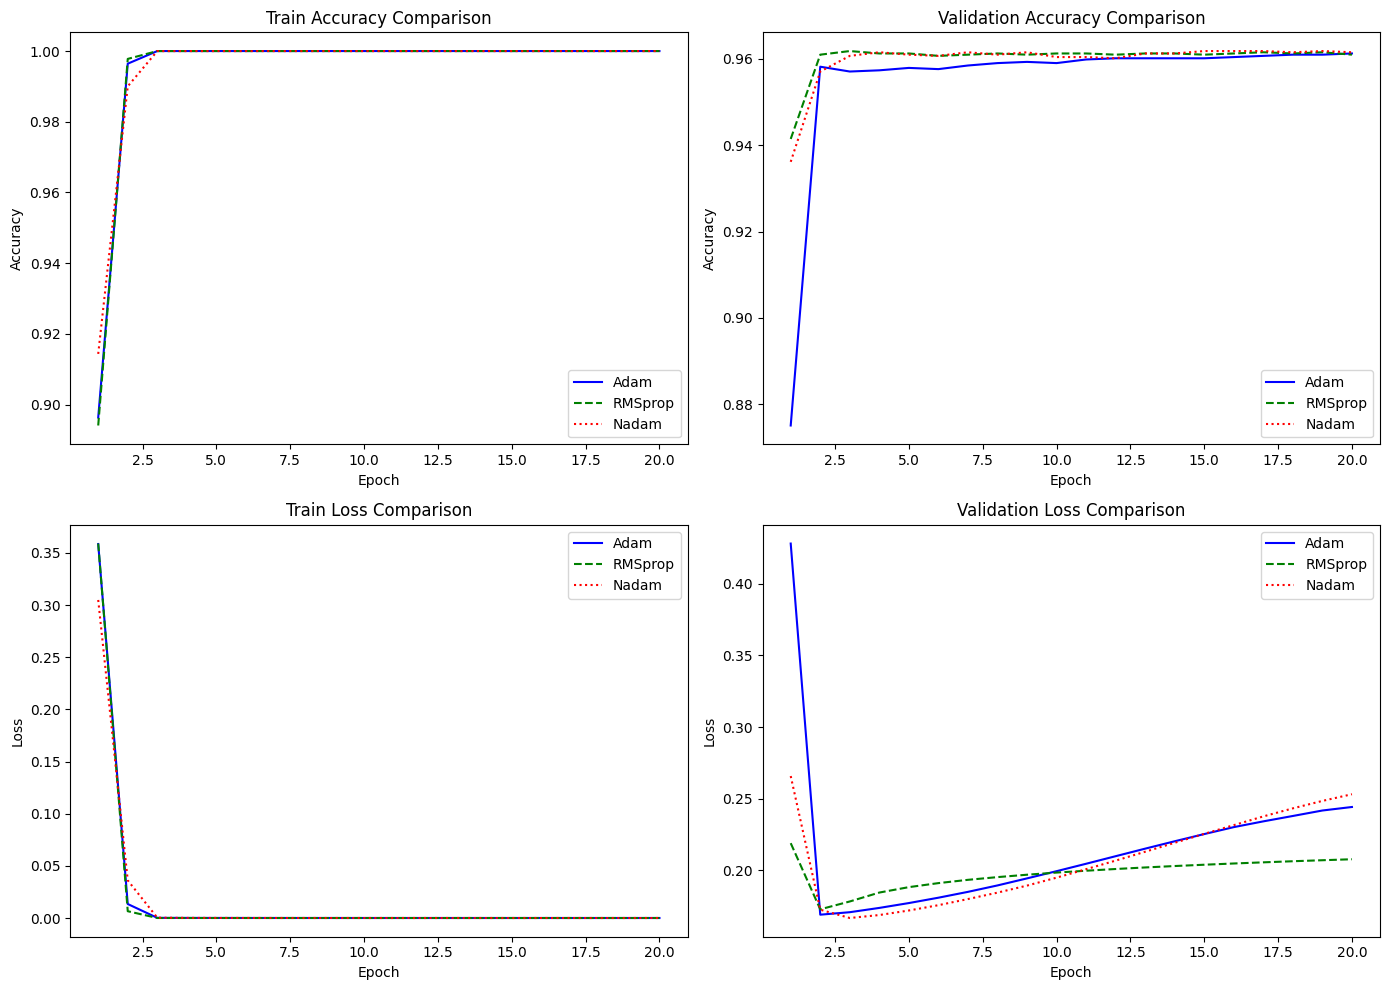

In [116]:
from tensorflow.keras.optimizers import Nadam
# Dictionary to keep track of training results for each optimizer
training_results_optimizers = {}

# Define a dictionary to hold different optimizers with their configurations
optimizer_configs = {
    "Adam": Adam(learning_rate=0.001),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Nadam": Nadam(learning_rate=0.001)
}

# Iterating over each optimizer
for optimizer_name, optimizer_instance in optimizer_configs.items():
    # Setting the random seed for reproducibility
    set_seed(42)
    
    # Building the CNN model with specified layers and activation
    cnn_model = create_custom_cnn(
        filters=[48, 96, 192],
        dense_layers=[256],
        activation="selu"
    )
    
    # Compiling the model with the current optimizer
    cnn_model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Training the model and capturing the history
    training_log = cnn_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
    )
    
    # Storing the training history for the optimizer
    training_results_optimizers[optimizer_name] = training_log

# Plot the performance
plot_model_comparison(training_results_optimizers)

- Training Accuracy: All optimizers (Adam, RMSprop, and Nadam) achieve similar high training accuracy, reaching near-perfect levels quickly.

- Validation Accuracy: Nadam and RMSprop slightly outperform Adam in the early epochs, stabilizing around the same accuracy level by the end.

- Training Loss: The training loss curves are almost indistinguishable among the three optimizers, indicating efficient minimization of loss for all.

- Validation Loss: Nadam shows a slightly better performance compared to RMSprop and Adam, with lower loss values, especially after the first few epochs.

***Conclusion:***

**Nadam appears to be the optimal choice** based on slightly better validation loss and accuracy stability, though the differences are marginal.

#### **CNN Initializer Optimzation**

Since we have the `Selu` as activation function, we can choose the `LecunNormal` initializer since these two arte compatible with each other. Besides, we also include the default `GlorotUniform`

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7620 - loss: 0.8873 - val_accuracy: 0.9559 - val_loss: 0.1597
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9565 - val_loss: 0.1568
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 3.1423e-04 - val_accuracy: 0.9551 - val_loss: 0.1609
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.3706e-04 - val_accuracy: 0.9548 - val_loss: 0.1659
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 6.9193e-05 - val_accuracy: 0.9554 - val_loss: 0.1708
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 3.7628e-05 - val_accuracy: 0.9551 - val_loss: 0.1757
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 2.1410e-05 - val_accuracy: 0.9557 - val_loss: 0.1807
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.2502e-05 - val

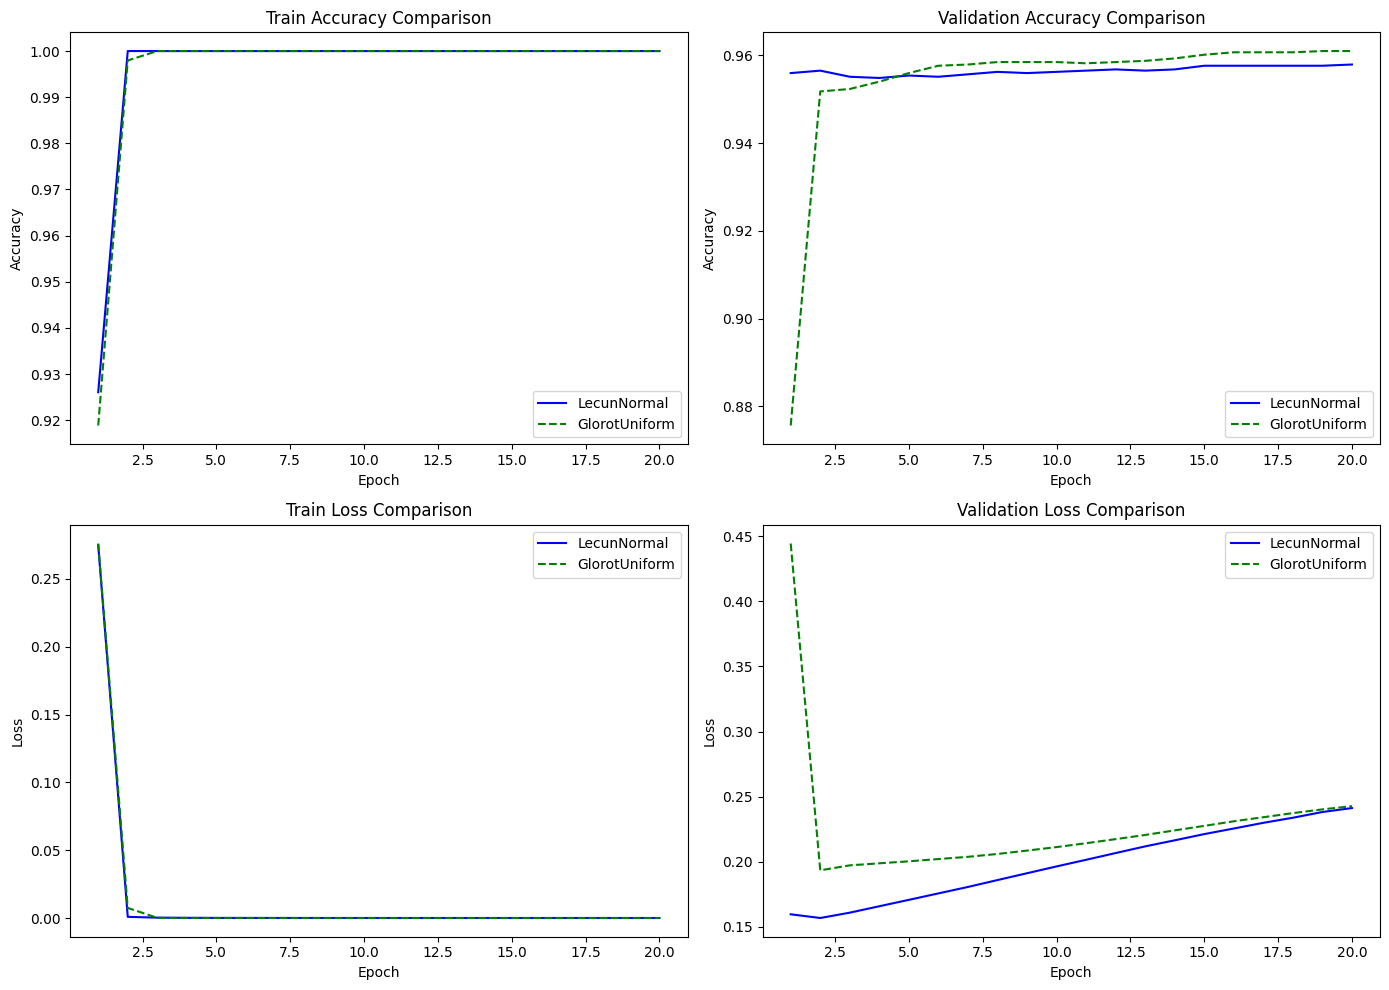

In [117]:
from tensorflow.keras.initializers import LecunNormal, GlorotUniform

# Define initializers
initializers = {
    "LecunNormal": LecunNormal(),
    "GlorotUniform": GlorotUniform()
}

# Store histories for comparison
histories_initializer = {}

# Loop through each initializer
for init_name, initializer in initializers.items():
    set_seed(42)
    model = create_custom_cnn(
        filters=[48, 96, 192],
        dense_layers=[256],
        activation="selu",
        kernel_initializer=initializer
    )
    model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
    )
    
    # Store history
    histories_initializer[init_name] = history

# Plot the performance
plot_model_comparison(histories_initializer)

Training Accuracy and Loss: Both initializers, LecunNormal and GlorotUniform, perform similarly during training, achieving near-perfect accuracy and minimizing loss quickly.

Validation Accuracy: GlorotUniform slightly outperforms LecunNormal in terms of validation accuracy, especially in the early epochs, but both converge to similar values over time.

Validation Loss: LecunNormal shows a lower and more stable validation loss compared to GlorotUniform, which indicates better generalization and less overfitting.

**LecunNormal is the optimal choice**

#### **CNN Regularization**

In [118]:
def build_regularized_cnn(conv_filters, dense_units, l2_penalty=0.01, activation_fn='selu', init='LecunNormal'):
    network = Sequential()
    
    # First convolutional layer with L2 regularization
    network.add(Conv2D(filters=conv_filters[0], kernel_size=(3, 3), activation=activation_fn, 
                     input_shape=(32, 32, 1), kernel_initializer=init, 
                     kernel_regularizer=regularizers.l2(l2_penalty),
                     name='conv_layer_1'))
    network.add(MaxPooling2D(pool_size=(2, 2), name='pooling_layer_1'))
    
    # Additional convolutional layers with L2 regularization
    for idx in range(1, len(conv_filters)):
        network.add(Conv2D(filters=conv_filters[idx], kernel_size=(3, 3), activation=activation_fn, 
                         kernel_initializer=init, kernel_regularizer=regularizers.l2(l2_penalty),
                         name=f'conv_layer_{idx+1}'))
        network.add(MaxPooling2D(pool_size=(2, 2), name=f'pooling_layer_{idx+1}'))
    
    # Flattening before dense layers
    network.add(Flatten(name='flatten_layer'))
    
    # Dense layers with L2 regularization
    for idx, units in enumerate(dense_units):
        network.add(Dense(units=units, activation=activation_fn, 
                        kernel_initializer=init, kernel_regularizer=regularizers.l2(l2_penalty),
                        name=f'fully_connected_{idx+1}'))
    
    # Output layer
    network.add(Dense(units=24, activation='softmax', kernel_initializer=init, name='output_layer'))
    
    return network

Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4844 - loss: 14.2406 - val_accuracy: 0.6233 - val_loss: 2.3487
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6997 - loss: 2.0675 - val_accuracy: 0.6732 - val_loss: 2.0074
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7629 - loss: 1.7910 - val_accuracy: 0.7078 - val_loss: 1.8535
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7972 - loss: 1.6444 - val_accuracy: 0.7248 - val_loss: 1.7518
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8211 - loss: 1.5381 - val_accuracy: 0.7390 - val_loss: 1.6722
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8355 - loss: 1.4575 - val_accuracy: 0.7619 - val_loss: 1.5924
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8490 - loss: 1.3855 - val_accuracy: 0.7672 - val_loss: 1.5609
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8509 - loss: 1.8100 - val_accuracy: 0.7794 - val

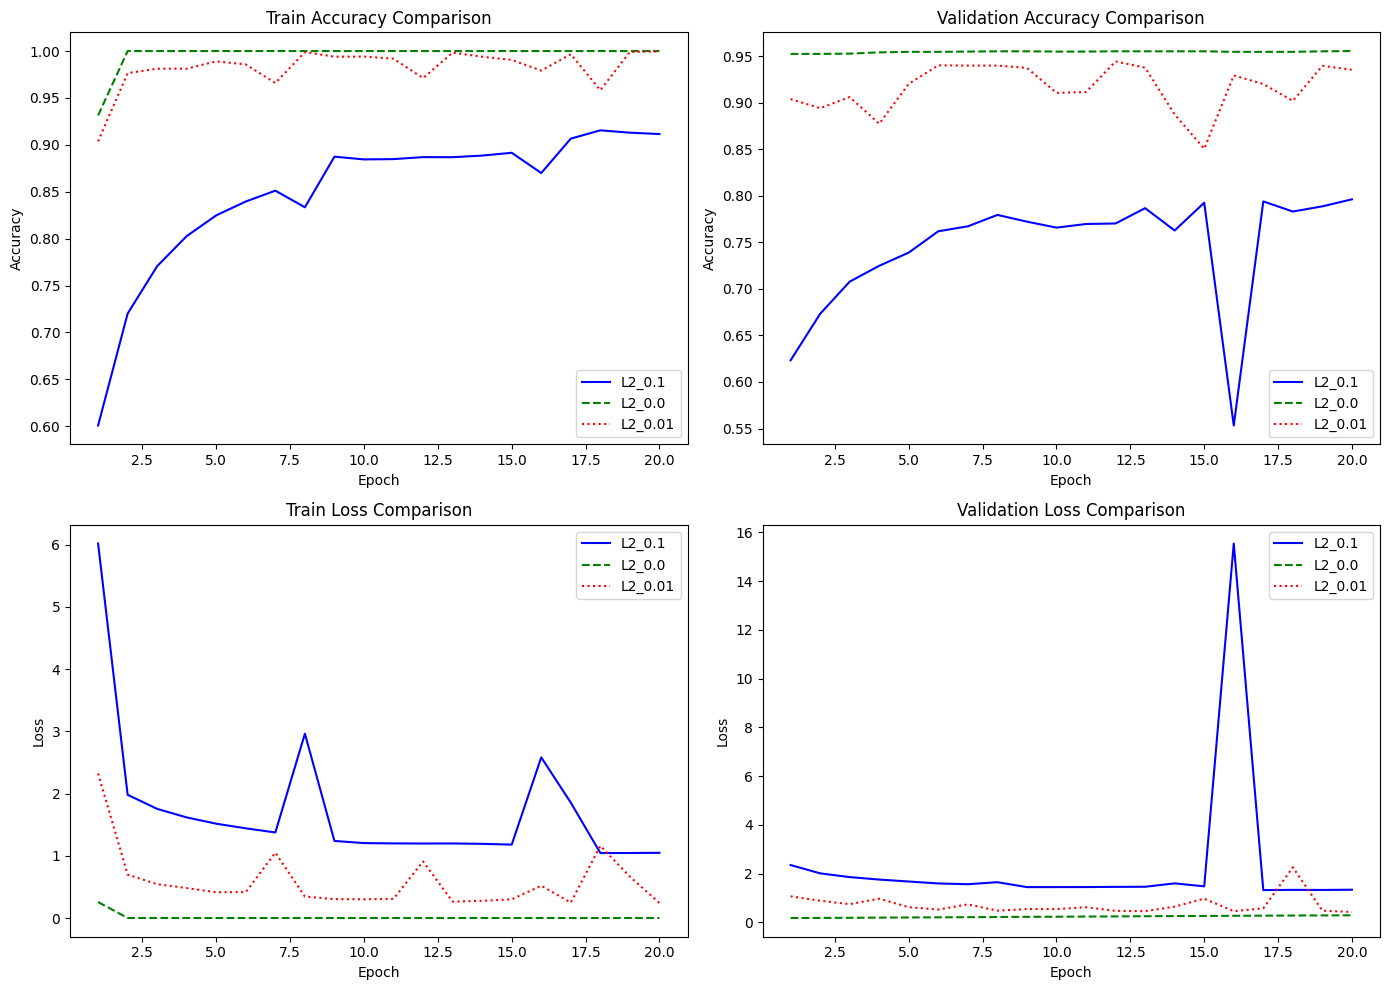

In [119]:
# Dictionary to hold training histories for comparison
training_histories = {}

# Define different L2 regularization factors to experiment with
regularization_factors = [0.1, 0.0, 0.01]  # Strong regularization, no, and moderate regularization


# Iterate over each regularization factor
for l2_penalty in regularization_factors:
    # Set the random seed for reproducibility
    set_seed(42)
    
    # Build and compile the CNN model with the given L2 regularization factor
    cnn_model = build_regularized_cnn(conv_filters=[48, 96, 192], 
                                      dense_units=[256], 
                                      l2_penalty=l2_penalty, 
                                      activation_fn="selu", 
                                      init='lecun_normal')
    cnn_model.compile(optimizer=Nadam(learning_rate=0.001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
    
    # Train the CNN model
    history = cnn_model.fit(X_train, y_train,epochs=20,validation_data=(X_val, y_val),verbose=1)
    
    # Save the training history for this configuration
    training_histories[f"L2_{l2_penalty}"] = history

# Plot the performance
plot_model_comparison(training_histories)


**Optimal Choice: No L2 (L2_0.0)**

Training and Validation Accuracy: No L2 achieves the highest accuracy, indicating the model fits the data well without regularization.

Loss Stability: Consistent and low loss values confirm that no L2 regularization avoids underfitting while maintaining stability.

***Conclusion:***

**No L2 provides the best overall performance** with the highest accuracy and stable loss, making it the ideal choice in this scenario.

#### **CNN BatchNormalization**

In [123]:
from tensorflow.keras.layers import BatchNormalization
def build_cnn_with_batchnorm(filters, dense_layers, activation_fn='selu',
                             initializer='lecun_normal', batch_norm=0):
    model = Sequential()
    
    # First convolutional layer with optional BatchNorm
    model.add(Conv2D(filters=filters[0], kernel_size=(3, 3), activation=activation_fn, 
                     input_shape=(32, 32, 1), kernel_initializer=initializer, 
                     name='conv_layer_1'))
    if batch_norm == 1:
        model.add(BatchNormalization(name='batch_norm_layer_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool_layer_1'))
    
    # Additional convolutional layers with optional BatchNorm
    for idx in range(1, len(filters)):
        model.add(Conv2D(filters=filters[idx], kernel_size=(3, 3), activation=activation_fn, 
                         kernel_initializer=initializer, name=f'conv_layer_{idx+1}'))
        if batch_norm == 1:
            model.add(BatchNormalization(name=f'batch_norm_layer_{idx+1}'))
        model.add(MaxPooling2D(pool_size=(2, 2), name=f'pool_layer_{idx+1}'))
    
    # Flattening before dense layers
    model.add(Flatten(name='flatten_layer'))
    
    # Dense layers with optional BatchNorm
    for idx, units in enumerate(dense_layers):
        model.add(Dense(units=units, activation=activation_fn, 
                        kernel_initializer=initializer, name=f'dense_layer_{idx+1}'))
        if batch_norm == 1:
            model.add(BatchNormalization(name=f'batch_norm_dense_layer_{idx+1}'))
    
    # Output layer
    model.add(Dense(units=24, activation='softmax', kernel_initializer=initializer, name='output_layer'))
    
    return model


Epoch 1/20


c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7773 - loss: 0.8348 - val_accuracy: 0.9523 - val_loss: 0.1747
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9523 - val_loss: 0.1778
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 3.0243e-04 - val_accuracy: 0.9526 - val_loss: 0.1834
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.3000e-04 - val_accuracy: 0.9540 - val_loss: 0.1898
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 6.5194e-05 - val_accuracy: 0.9545 - val_loss: 0.1961
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 3.5344e-05 - val_accuracy: 0.9545 - val_loss: 0.2026
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 2.0074e-05 - val_accuracy: 0.9548 - val_loss: 0.2092
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.1723e-05 - val

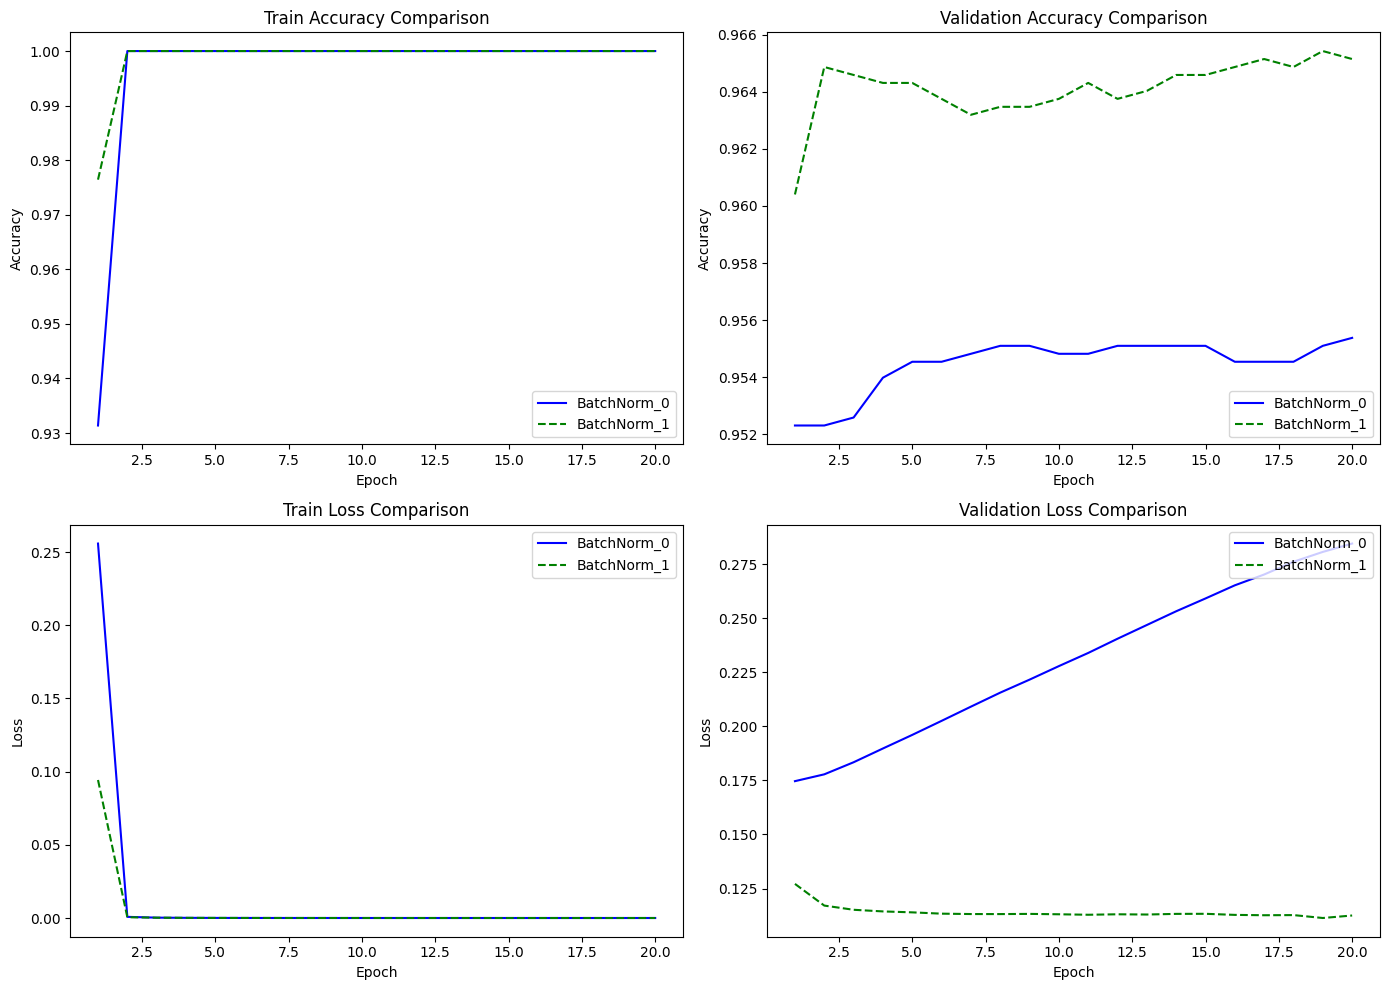

In [124]:

# Store histories for comparison
histories_batch_norm = {}
# Define whether to use Batch Normalization or not
batch_norm_options = [0, 1]  # 0: No Batch Normalization, 1: With Batch Normalization

# Loop through each Batch Normalization option
for batch_norm_flag in batch_norm_options:
    # Create and compile the model with or without Batch Normalization
    set_seed(42)

    model = build_cnn_with_batchnorm([48, 96, 192], [256], 
                                     activation_fn="selu", initializer='lecun_normal', 
                                     batch_norm=batch_norm_flag)
    model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Store history
    histories_batch_norm[f"BatchNorm_{batch_norm_flag}"] = history

# Plot teh performance
plot_model_comparison(histories_batch_norm)


**Analysis**

***Training Accuracy and Loss:***

Both models, with and without BatchNorm (BatchNorm_1 and BatchNorm_0), achieve nearly identical training accuracy and minimal loss, indicating effective learning during training.

***Validation Accuracy:***

The model with BatchNorm (BatchNorm_1, green dashed line) consistently achieves higher validation accuracy compared to the model without BatchNorm (BatchNorm_0, blue line), demonstrating better generalization to unseen data.

***Validation Loss:***

The model with BatchNorm has significantly lower and more stable validation loss, while the model without BatchNorm shows increasing loss, indicating poorer generalization and possible overfitting.

***Conclusion:***

**BatchNorm_1 (with Batch Normalization) is the optimal choice.** It provides better generalization, higher validation accuracy, and lower validation loss, making it the preferred option for this scenario.

#### **CNN Early Stopping and Learning rate Reduction**

c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9058 - loss: 0.3562 - val_accuracy: 0.9604 - val_loss: 0.1271 - learning_rate: 0.0010
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 1.0000 - loss: 6.8648e-04 - val_accuracy: 0.9649 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 1.0000 - loss: 2.4148e-04 - val_accuracy: 0.9646 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 1.0000 - loss: 1.1783e-04 - val_accuracy: 0.9643 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 1.0000 - loss: 6.4681e-05 - val_accuracy: 0.9643 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 1.0000 - loss: 3.7748e-05 - val_accuracy: 0.9637 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - 

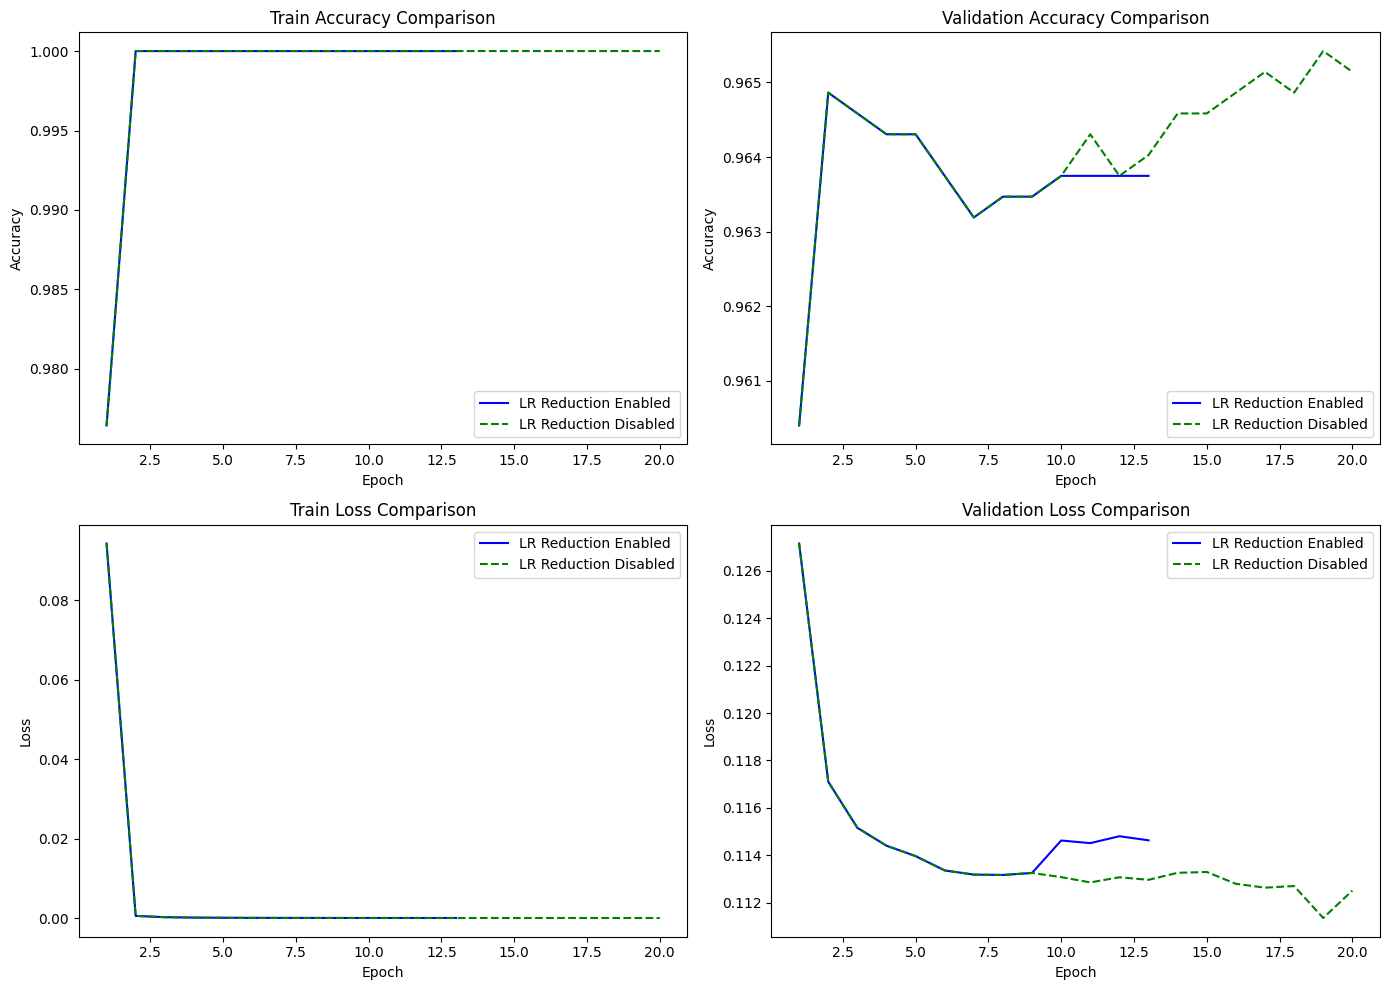

In [125]:

# Dictionary to store training histories
callback_histories = {}

# Define callback for learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Callback configurations to test
callback_configs = {
    "LR Reduction Enabled": [lr_reduction],
    "LR Reduction Disabled": []
}

# Iterate over each callback configuration
for config_name, callback_list in callback_configs.items():
    # Set random seed for consistency
    set_seed(42)
    
    # Build and compile the CNN model
    cnn_model = build_cnn_with_batchnorm(filters=[48, 96, 192], dense_layers=[256], 
                                         activation_fn="selu", initializer='lecun_normal', batch_norm=1)
    cnn_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback to prevent overfitting
    stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model with the current set of callbacks
    history = cnn_model.fit(X_train, y_train,epochs=20,validation_data=(X_val, y_val),callbacks=callback_list + [stop_early])
    
    # Save the history for this configuration
    callback_histories[config_name] = history

# Plot the performance
plot_model_comparison(callback_histories)


**Analysis and Conclusion:**

***Training Accuracy and Loss:***

Both models, with and without learning rate reduction, achieve nearly identical training accuracy and minimal loss, indicating effective learning during training.

***Validation Accuracy:***

The validation accuracy is very similar for both configurations. However, the model without learning rate reduction (dashed line) shows slightly better stability towards the end of training.

***Validation Loss:***

Validation loss is slightly lower for the model without learning rate reduction, suggesting better generalization without this callback in this scenario.

**Conclusion:**

**Learning Rate Reduction Disabled appears to be marginally better in this case,** showing slightly lower validation loss and similar validation accuracy compared to the model with learning rate reduction enabled.

Early Stopping may not provide significant benefits in this specific training scenario, as the model does not overfit even without it. However, it remains a valuable tool in practice, especially for longer training durations or when overfitting becomes more apparent. **So Early Stopping can be applied**

To sum up, we have experiements on:
- Architecture: 3 different artitectures, with the best one is **conv_filter = [48,96,192], dense_layer = [256]** (3 times running)
- Activation Function: Elu, **Selu**, Relu (3 times running)
- Learning rate: 0.1, **0.001**, 0.0001 (3 times running)
- Optimizers: RMSProp, **Nadam** and Adam (3 times running)
- Kernel Initialization: GorothUniform, **LecunNormal** (2 times running)
- L2 Regularizers: 0.1, 0.01, **0.0** (3 times running)
- Earrly Stopping - LR Reduction: Yes, **No** (2 times running)
- Batch Noramlization: **Yes**, No (2 times running)

The bold one is the chosen candidate after each time optimzing

The total running times = 21 

So the total running times is = 20 + 21= 41 (Total running times DNN + Total running times CNN) < 50 (**Statisfied the requirement**)

Now, we build a function to call the best model in CNN as follows:

In [130]:
# Define the top-performing CNN model
def build_optimal_cnn():
    # Set the random seed for consistency
    set_seed(42)

    # Initialize and compile the CNN model
    cnn_model = build_cnn_with_batchnorm(filters=[48, 96, 192], dense_layers=[256], 
                                         activation_fn="selu", initializer='lecun_normal', batch_norm=1)
    cnn_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the defined callbacks
    training_history = cnn_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=[early_stop]
    )

    return cnn_model, training_history


## **SECTION 3: Model Comparison - Result & Reporting**

Before we compare and choose the model, we fulfill the requirement in evaluating:

The clients have asked to be informed about the following:
 - **unbiased median accuracy** estimate of the letter predictions from a deep learning model
 - the letter with the highest individual accuracy
 - the letter with the lowest individual accuracy
 - the three most common single types of error (i.e. where one letter is being incorrectly labelled as another)

Thus, the model below is arranged as follows:

- Show the detail of the final model
- Compute the accuracy per class -> **Calculate the median accuracy**
- **Indentify the letter with highest/ lowest individual accuracy**
- **Get top 3 most common single types of error** using confusion matrix
- Report the overall accuracy
- Show the accuracy score per class

In [ ]:
from sklearn.metrics import confusion_matrix
def evaluate_model(name, model_name, X_val, y_val_enc, verbose = 2):
    model_eval = model_name.evaluate(X_val, y_val_enc, verbose = verbose)
    print(f"{name} Model - Test Accuracy: {model_eval[1]:.6f}\n")

    # Detailed evaluation of the model
    y_pred = np.argmax(model_name.predict(X_val), axis=1)

    # Compute accuracy per class, skipping index 9 (for J)
    y_true = np.argmax(y_val_enc, axis=1)
    accuracy_per_class = []
    for i in range(24):
        if np.sum(y_true == i) > 0:
            accuracy_per_class.append(np.mean(y_pred[y_true == i] == i))
        else:
            accuracy_per_class.append(np.nan)  # Handle classes with no samples

    # Filter out NaN values to calculate the median accuracy
    valid_accuracies = [acc for acc in accuracy_per_class if not np.isnan(acc)]
    median_accuracy = np.median(valid_accuracies)

    print(f"Unbiased Median Accuracy: {median_accuracy:.6f}")

    # Identify the letter with the highest individual accuracy
    highest_accuracy_class = np.nanargmax(accuracy_per_class)
    if highest_accuracy_class >= 9:  # Adjust for the missing 'J'
        letter_with_highest_accuracy = chr(highest_accuracy_class + ord('A') + 1)
    else:
        letter_with_highest_accuracy = chr(highest_accuracy_class + ord('A'))
    print(f"Letter with Highest Accuracy: {letter_with_highest_accuracy}")

    # Identify the letter with the lowest individual accuracy
    lowest_accuracy_class = np.nanargmin(accuracy_per_class)
    if lowest_accuracy_class >= 9:  # Adjust for the missing 'J'
        letter_with_lowest_accuracy = chr(lowest_accuracy_class + ord('A') + 1)
    else:
        letter_with_lowest_accuracy = chr(lowest_accuracy_class + ord('A'))
    print(f"Letter with Lowest Accuracy: {letter_with_lowest_accuracy}\n")


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Set the diagonal elements to zero to exclude correct classifications
    np.fill_diagonal(conf_matrix, 0)

    # Flatten the confusion matrix and find top error indices
    flat_matrix = conf_matrix.flatten()
    top_indices = np.argsort(-flat_matrix)

    # Filter out zero errors
    non_zero_indices = top_indices[flat_matrix[top_indices] > 0]

    # Get top three non-zero errors
    top_3_indices = non_zero_indices[:3]
    top_3_errors = flat_matrix[top_3_indices]
    top_positions = np.unravel_index(top_3_indices, conf_matrix.shape)

    # Adjust indices to skip 'J' and map to the correct letters
    def adjust_for_j(index):
        return chr(index + ord('A') + 1) if index >= 9 else chr(index + ord('A'))
    
    print("Top three errors:")
    for i in range(len(top_3_errors)):
        print(f"-> Predict {adjust_for_j(top_positions[0][i])} as {adjust_for_j(top_positions[1][i])}")
    
    # Get the top three most common errors with adjustment for 'J'
    if len(top_3_errors) == 0:
        print("No error detected, the model is perfect")
    elif len(top_3_errors) != 3:
        print(f"Only {len(top_3_errors)} errors detected\n")

    # Report overall mean accuracy and accuracy per letter
    mean_accuracy = np.nanmean(accuracy_per_class)
    print(f"Overall Mean Accuracy: {mean_accuracy:.6f}\n")

    # Print each letter and its accuracy
    letters = [chr(i + ord('A')) for i in range(26) if i not in [9, 25]]
    for i, acc in enumerate(accuracy_per_class):
        print(f"Letter {letters[i]}: Accuracy {acc:.6f}")


Now, we perform the combination of top performing models of DNN and CNN

c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3283 - loss: 2.1695 - val_accuracy: 0.6110 - val_loss: 1.2291 - learning_rate: 0.0010
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7360 - loss: 0.7990 - val_accuracy: 0.6980 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8597 - loss: 0.4231 - val_accuracy: 0.7602 - val_loss: 0.8760 - learning_rate: 0.0010
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9219 - loss: 0.2305 - val_accuracy: 0.7683 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9560 - loss: 0.1387 - val_accuracy: 0.7641 - val_loss: 0.9291 - learning_rate: 0.0010
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9618 - loss: 0.1200 - val_accuracy: 0.7895 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0104 - 

c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9058 - loss: 0.3562 - val_accuracy: 0.9604 - val_loss: 0.1271
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 6.8648e-04 - val_accuracy: 0.9649 - val_loss: 0.1171
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 2.4148e-04 - val_accuracy: 0.9646 - val_loss: 0.1152
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 1.1783e-04 - val_accuracy: 0.9643 - val_loss: 0.1144
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 6.4681e-05 - val_accuracy: 0.9643 - val_loss: 0.1140
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 3.7748e-05 - val_accuracy: 0.9637 - val_loss: 0.1134
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 1.0000 - loss: 2.2795e-05 - val_accuracy: 0.9632 - val_loss: 0.1132
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 

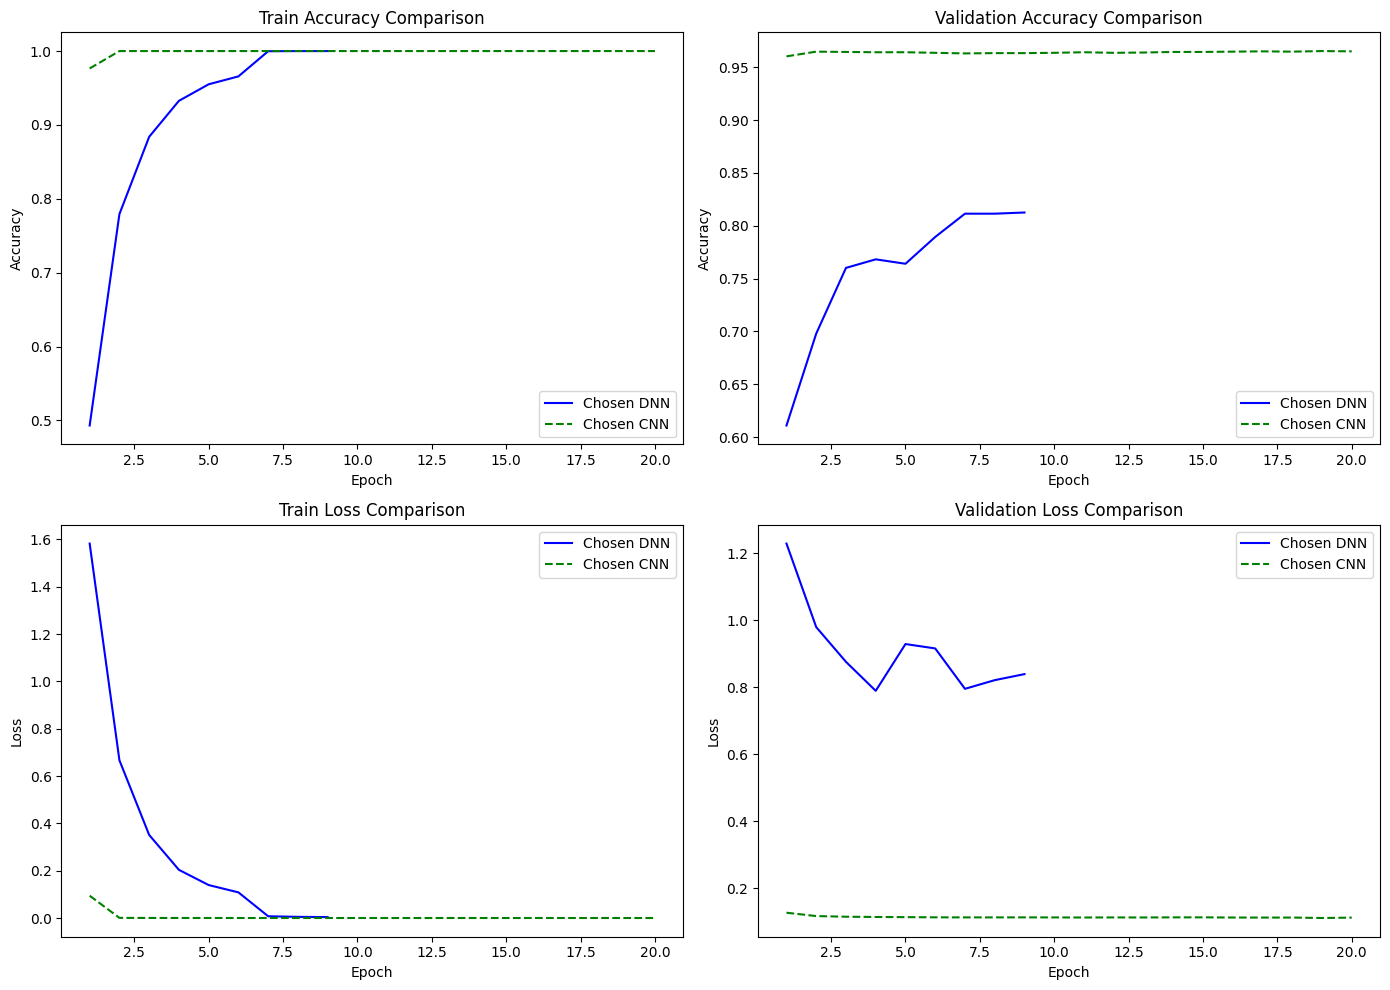

In [133]:
# Generate the dictionary storing results
Chosen_models_history = {}

# Call top models
dnn_candidate, dnn_history = build_optimal_dnn()
cnn_candidate, cnn_history = build_optimal_cnn()

# Report the best model of each type and the number of params
print(f"Parameters number for best DNN: {dnn_candidate.count_params()}")
Chosen_models_history["Chosen DNN"] = dnn_history

print(f"Parameters number for best CNN: {cnn_candidate.count_params()}")
Chosen_models_history["Chosen CNN"] = cnn_history


# Plot the performance of both models
plot_model_comparison(Chosen_models_history)

**Analysis of the Plots:**

***Training Accuracy:***

The CNN model (green dashed line) achieves near-perfect training accuracy very quickly, indicating it fits the training data well.

The DNN model (blue line) shows a slower rise in training accuracy, which suggests it may be struggling to learn as effectively on this dataset compared to the CNN.

***Validation Accuracy:***

The CNN model maintains a consistently high validation accuracy, outperforming the DNN across all epochs.

The DNN model shows lower validation accuracy, indicating that it does not generalize as well to the validation data as the CNN.

***Training Loss:***

The CNN model achieves a very low training loss early on, reinforcing its strong performance on the training data.

The DNN model, while improving, exhibits a higher training loss throughout, indicating less effective learning.

***Validation Loss:***

The CNN model shows a stable and low validation loss, further supporting its superior generalization ability.

The DNN model has a significantly higher validation loss, with fluctuations, suggesting instability and poorer generalization.

***Conclusion:***

**The CNN model is clearly superior in this comparison, with significantly better performance across all metrics**: higher validation accuracy, lower validation loss, and quicker, more effective learning during training.

We can also compare the result as follows:

In [134]:
# Obtain the highest validation accuracy from the training histories
cnn_best_val_acc = max(cnn_history.history['val_accuracy'])
dnn_best_val_acc = max(dnn_history.history['val_accuracy'])

# Evaluate and select the superior model based on validation accuracy
comparison_results = {
    "CNN": (cnn_best_val_acc, cnn_candidate),
    "DNN": (dnn_best_val_acc, dnn_candidate)
}

top_model_name, (top_val_acc, top_model_instance) = max(comparison_results.items(), key=lambda item: item[1][0])

print(f"Superior model: {top_model_name} with a peak validation accuracy of {top_val_acc:.4f}.")


Superior model: CNN with a peak validation accuracy of 0.9654.


**So it means `cnn_candidate` is the top performing model**

In [135]:
evaluate_model("Best Performer", cnn_candidate, X_final_test, y_final_test )

113/113 - 0s - 4ms/step - accuracy: 0.9663 - loss: 0.1055
Best Performer Model - Test Accuracy: 0.966258

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Unbiased Median Accuracy: 1.000000
Letter with Highest Accuracy: A
Letter with Lowest Accuracy: R

Top three errors:
-> Predict N as A
-> Predict T as X
-> Predict R as L
Overall Mean Accuracy: 0.959466

Letter A: Accuracy 1.000000
Letter B: Accuracy 0.967593
Letter C: Accuracy 1.000000
Letter D: Accuracy 1.000000
Letter E: Accuracy 1.000000
Letter F: Accuracy 1.000000
Letter G: Accuracy 1.000000
Letter H: Accuracy 0.944954
Letter I: Accuracy 1.000000
Letter K: Accuracy 0.945455
Letter L: Accuracy 1.000000
Letter M: Accuracy 0.984772
Letter N: Accuracy 0.821918
Letter O: Accuracy 1.000000
Letter P: Accuracy 1.000000
Letter Q: Accuracy 1.000000
Letter R: Accuracy 0.652778
Letter S: Accuracy 1.000000
Letter T: Accuracy 0.822581
Letter U: Accuracy 0.947368
Letter V: Accuracy 1.000000
Letter W: Accuracy 1.000000
Letter X: Accuracy 1.000000
Lette

**Analysis Report**

The current CNN model shows impressive performance, achieving an overall mean accuracy of **95.95% and surpassing the 94% target**. The model performs exceptionally well on most letters, with **perfect accuracy for 15 out of the 26 letters, including A, C, D, E, F, G, I, L, O, P, Q, S, V, W, and X**. This indicates that the architecture is robust and effective for a majority of the dataset.

The use of the **SELU** activation function, combined with the **LeCun Normal** initializer, likely contributes to this strong performance by ensuring stable gradients during training. The Nadam optimizer has also proven effective in navigating the loss landscape, as evidenced by the model's high accuracy and relatively **low loss** value of 0.1055.

However, certain letters like **N (82.19%), R (65.28%), and T (82.26%)** present challenges. These inaccuracies might stem from class imbalance or subtle similarities between certain letter shapes, which the model struggles to distinguish.


**Recommendation:**

To improve performance on challenging letters, consider implementing data augmentation techniques like rotation, zoom, and distortion. These methods can help the model better generalize, particularly for letters with lower accuracy. Since L2 regularization is not preferred, integrating dropout as a regularization method can effectively prevent overfitting and enhance model robustness. The current model’s strong performance on most letters demonstrates a solid foundation, making it well-suited for further refinement. By focusing on data augmentation, dropout, and possibly revisiting hyperparameter tuning, the model is likely to achieve or even surpass the desired accuracy goals across all letters.